In [2]:
import numpy as np
import Plot as plot
import math
import matplotlib.pyplot as plt
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.offline as offline
import time
import datetime
import pickle
import os
import scipy.spatial
from scipy.spatial import distance
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib as plt
import logging
from scipy import signal
import learningAlgs as classImportLA
import dataManipulation as dataMan
from itertools import permutations
import importlib
from datetime import timedelta
from multiprocessing import Pool
import multiprocessing
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.cluster import KMeans
import timeIntervalPlotter as intervalPlotter
import pysal
import warnings
import lumping_traditional as oldLumping
import boundaryFull_SS_WeightedLumping as WLumping
from importlib import reload
from scipy.stats import rayleigh
import dataManipulation as dataMan
import matplotlib.pyplot as plt
import processData as processData
import tensorflow as tf
import random
from random import shuffle

warnings.filterwarnings('always')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Fetching Data and Creating Transition Matrix

In [3]:
dataFrame = processData.processingData()
#address is: /home/netlab/Desktop/thesis/data/1node1-3-5/
#/home/netlab/Desktop/thesis/data/500f80271400/
data = dataFrame.copy() #copying the dataFrame to have a copy of not edited data

data = processData.dataFrameManipulation(data)

the address of the collected data files (not alligned files or CSV files): /home/sepehr/thesis/data/500f80271400/
['500f80271400.txt']
here
500f80271400.txt is in csvChecker

we have the csv file: pulling out data

   col1                time  CU
0     0 2018-11-13 02:01:32  45
1     1 2018-11-13 02:01:38  45
2     2 2018-11-13 02:01:44  51
3     3 2018-11-13 02:01:50  53
4     4 2018-11-13 02:01:56  45
now we have the processed data from pandas
please enter how long would be the chunk minutes? 10
removing weekends from the data


In [4]:
numberOfStates = 255
cuTrans_10min = processData.markovianTransitionMatrixDegree1(data, numberOfStates, "CU")
normalizedCuTrans_10min = processData.normalizingTransMatrix(cuTrans_10min)

# Calculating days and shuffling with seed to create Correlations

In [5]:
def dayCalculator(x):
    years = x["time"].year - data["time"][0].year
    months = x["time"].month - data["time"][0].month
    days = x["time"].day - data["time"][0].day
    return ((years*12*30) + (months*30) + days)
data["day"] = data.apply(lambda x: dayCalculator(x), axis = 1)

In [6]:
uniqueDays = []
uniqueDays.extend(data.apply(lambda x: x["day"] if x["day"] not in uniqueDays else np.inf, axis = 1))
uniqueDays = list(set(uniqueDays))
random.Random(0).shuffle(uniqueDays)

days30 = uniqueDays[0:30]
data_within_30Days = data.loc[data["day"].isin(days30)]

In [7]:
numberOfStates = 255
cuTrans_30Days = processData.markovianTransitionMatrixDegree1(data_within_30Days, numberOfStates, "CU")
normalizedCuTrans_30Days = processData.normalizingTransMatrix(cuTrans_30Days)

In [8]:
from scipy import signal
pd.options.mode.chained_assignment = None
steadyState_30days = np.zeros(shape=(normalizedCuTrans_30Days.shape[0],
                                     normalizedCuTrans_30Days.shape[1]))
for i in range(normalizedCuTrans_30Days.shape[0]):
    steadyState_30days[i] = abs(pysal.spatial_dynamics.ergodic.steady_state(normalizedCuTrans_30Days[i]))

In [19]:
max(data["timeIndex"])

143.0

# Calculating Correlations

In [10]:
for x in range(max(data["timeIndex"])+1):
    data["corr" + str(x + 1)] = np.inf

In [11]:
print(uniqueDays)
for j in uniqueDays:
    print(j)
    for i in range(max(data["timeIndex"])+1):
        data_correlation = data.loc[(data["timeIndex"] == i) & (data["day"] == j)].copy()
        if len(data_correlation) == 0:
            continue
        cuTran_corr = processData.markovianTransitionMatrixDegree1(data_correlation, numberOfStates, "CU")
        for x in range(cuTran_corr[-1].shape[0]):
            if np.sum(cuTran_corr[-1][x]) == 0:
                continue
            cuTran_corr[-1][x] = cuTran_corr[-1][x] / np.sum(cuTran_corr[-1][x])
        steadyState_corr = abs(pysal.spatial_dynamics.ergodic.steady_state(cuTran_corr[-1]))

        steadyState_corr_normalize = (steadyState_corr - np.mean(steadyState_corr)) / (
            np.std(steadyState_corr) * len(steadyState_corr))
        
        correlationDistance = []
        
        for x in range(max(data["timeIndex"])+1):
            ss_normalize = (steadyState_30days[x] - np.mean(steadyState_30days[x])) / (
                np.std(steadyState_30days[x]))
            data["corr" + str(x + 1)].loc[(data["timeIndex"] == i) & (data["day"] == j)] = signal.correlate(
                steadyState_corr_normalize, ss_normalize, mode="valid")[0]

[31, 10, 15, 9, 185, 17, 1, 252, 257, 195, 22, 205, 191, 167, 238, 2, 184, 246, 224, 210, 25, 8, 32, 14, 201, 147, 30, 146, 240, 161, 254, 236, 177, 264, 245, 141, 153, 219, 178, 18, 243, 216, 4, 28, 21, 29, 148, 223, 198, 211, 218, 189, 215, 35, 260, 183, 259, 0, 217, 154, 199, 253, 3, 258, 197, 251, 36, 164, 196, 250, 247, 202, 168, 11, 239, 163, 24, 225, 212, 149, 237, 16, 244, 160, 23, 208, 37, 222, 182, 203, 162, 190, 204, 209, 150, 7, 192, 188]
31
10
15
9
185
17
1
252
257
195
22
205
191
167
238
2
184
246
224
210
25
8
32
14
201
147
30
146
240
161
254
236
177
264
245
141
153
219
178
18
243
216
4
28
21
29
148
223
198
211
218
189
215
35
260
183
259
0
217
154
199
253
3
258
197
251
36
164
196
250
247
202
168
11
239
163
24
225
212
149
237
16
244
160
23
208
37
222
182
203
162
190
204
209
150
7
192
188


# Creating Staionary Process Values

In [17]:
copy_data = data.copy()
data["logDiff"] = np.inf
data["log"] = np.inf
data["normalLogDiff"] = np.inf

In [18]:
for i in range(np.max(data["timeIndex"]) + 1):
    dataTimeIndex = data.loc[data["timeIndex"] == i]
    dataTimeIndex["log"] = np.log(dataTimeIndex["CU"])
    dataTimeIndex = dataTimeIndex.loc[dataTimeIndex["log"] != -np.inf]
    dataTimeIndex = dataTimeIndex.loc[dataTimeIndex["log"] != np.inf]
    dataTimeIndex = dataTimeIndex.dropna()
    
    dataTimeIndex["logDiff"] = dataTimeIndex["log"].diff()
    dataTimeIndex = dataTimeIndex.loc[dataTimeIndex["logDiff"] != -np.inf]
    dataTimeIndex = dataTimeIndex.loc[dataTimeIndex["logDiff"] != -np.inf]
    dataTimeIndex = dataTimeIndex.dropna()
    
    dataTimeIndex["normalLogDiff"] = dataTimeIndex["logDiff"] / np.max(dataTimeIndex["logDiff"])
    data.loc[data["timeIndex"] == i] = dataTimeIndex
    
data = data.loc[data["log"] != np.inf]
data = data.loc[data["log"] != -np.inf]
data = data.dropna()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeW

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeW

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log



# Writing Feature Engineered DataFrame into a Pickle

In [20]:
data["timeIndex"] = data["timeIndex"].astype(int)
data.to_pickle("10min_featureEngineer.pickle")

In [19]:
data.head()

,col1,time,CU,CU/255,timeIndex,weekDay,day,corr1,corr2,corr3,...,corr66,corr67,corr68,corr69,corr70,corr71,corr72,logDiff,log,normalLogDiff
1,1.0,2018-11-12 19:01:38,45.0,0.176471,57,0.0,0.0,0.797445,0.789106,0.803848,...,0.822679,0.839345,0.814206,0.781813,0.804814,0.798997,0.807548,0.000000,3.806662,0.000000
2,2.0,2018-11-12 19:01:44,51.0,0.200000,57,0.0,0.0,0.797445,0.789106,0.803848,...,0.822679,0.839345,0.814206,0.781813,0.804814,0.798997,0.807548,0.125163,3.931826,0.078328
3,3.0,2018-11-12 19:01:50,53.0,0.207843,57,0.0,0.0,0.797445,0.789106,0.803848,...,0.822679,0.839345,0.814206,0.781813,0.804814,0.798997,0.807548,0.038466,3.970292,0.024072
4,4.0,2018-11-12 19:01:56,45.0,0.176471,57,0.0,0.0,0.797445,0.789106,0.803848,...,0.822679,0.839345,0.814206,0.781813,0.804814,0.798997,0.807548,-0.163629,3.806662,-0.102400
5,5.0,2018-11-12 19:02:02,45.0,0.176471,57,0.0,0.0,0.797445,0.789106,0.803848,...,0.822679,0.839345,0.814206,0.781813,0.804814,0.798997,0.807548,0.000000,3.806662,0.000000


In [21]:
data = pd.read_pickle("10min_featureEngineer.pickle")

In [22]:
numberOfStates = 255
cuTrans = processData.markovianTransitionMatrixDegree1(data, numberOfStates, "CU")
normalizedCuTrans = processData.normalizingTransMatrix(cuTrans)

In [23]:
def preparingMatrixForLumping(transitionMatrix):
    reload(oldLumping)
    percentageMatrix_list = bandwidthPercentage(transitionMatrix)
    zero_cols_rows = []
    #*************removing zeros from columns and rows (matrix reduction) ****************
    for i in range(len(transitionMatrix)):
        if (np.sum(transitionMatrix[i]) == 0) and (np.sum(transitionMatrix[:,i]) == 0):
            zero_cols_rows.append(i)


    irreducible_matrix = transitionMatrix.copy()
    for i in range(len(zero_cols_rows) - 1, -1, -1):
        irreducible_matrix = np.delete(irreducible_matrix, zero_cols_rows[i], axis = 0)
        irreducible_matrix = np.delete(irreducible_matrix, zero_cols_rows[i], axis = 1)
        percentageMatrix_list[zero_cols_rows[i]][2] = True


    for i in range(len(percentageMatrix_list) - 1, 0, -1):
        if (percentageMatrix_list[i][2] == True) and (percentageMatrix_list[i - 1][2] == True):
            percentageMatrix_list[i - 1][0].extend(percentageMatrix_list[i][0])
            percentageMatrix_list[i - 1][1] = percentageMatrix_list[i][1]
            del percentageMatrix_list[i]

    for i in range(len(irreducible_matrix)):
        if np.sum(irreducible_matrix[i], dtype = np.float32) != 1.0:
            print(np.sum(irreducible_matrix[i], dtype = np.float32))

    return percentageMatrix_list, irreducible_matrix

def bandwidthPercentage(vectorMatrix):
    percentageIncreament = (100 / vectorMatrix.shape[0])
    percentageMatrix = []
    maxPercentage = 0
    for j in range(vectorMatrix.shape[0]):
        maxPercentage += percentageIncreament
        percentageMatrix.append([[j], maxPercentage, False])

    return percentageMatrix

In [24]:
reload(oldLumping)

<module 'lumping_traditional' from '/home/sepehr/thesis/APDataML/lumping_traditional.py'>

In [26]:
normalizedCuTrans.shape

(144, 255, 255)

In [27]:
for i in range((max(data["timeIndex"]) + 1)):
    percentageMatrix_list, irreducible_matrix = preparingMatrixForLumping(normalizedCuTrans[i])
    result = oldLumping.lumping(irreducible_matrix, percentageMatrix_list, False)
    nameResult = "/home/sepehr/thesis/APDataML/pickles/5normal_25-10_lumping_10min_result_" + str(i) + ".pickle"
    with open(nameResult, 'wb') as handle:
        pickle.dump(result, handle)
    namePercent = "/home/sepehr/thesis/APDataML/pickles/5normal_25-10_lumping_10min_percentage_" + str(i) + ".pickle"
    with open(namePercent, 'wb') as handle:
        pickle.dump(percentageMatrix_list, handle)

0.99999994
0.99999994
1.0000001
we have these many sectors to check:  75220
0.99999994
0.99999994
0.99999994
we have these many sectors to check:  12966
0.99999994
0.99999994
0.99999994
0.99999994
1.0000001
we have these many sectors to check:  9388
0.99999994
we have these many sectors to check:  46338
1.0000001
we have these many sectors to check:  0
0.99999994
0.99999994
we have these many sectors to check:  2669
0.99999994
0.99999994
1.0000001
0.99999994
we have these many sectors to check:  0
0.99999994
0.99999994
we have these many sectors to check:  0
0.99999994
0.99999994
1.0000001
0.99999994
0.99999994
we have these many sectors to check:  3138
0.99999994
0.99999994
0.99999994
0.99999994
0.99999994
0.99999994
0.99999994
1.0000001
we have these many sectors to check:  0
0.99999994
0.99999994
1.0000001
1.0000001
1.0000001
we have these many sectors to check:  0
0.99999994
0.99999994
0.99999994
we have these many sectors to check:  4127
0.99999994
0.99999994
0.99999994
0.99999994

0.99999994
0.99999994
0.99999994
0.99999994
0.99999994
0.99999994
0.99999994
0.99999994
1.0000001
we have these many sectors to check:  308438
0.99999994
1.0000001
0.99999994
0.99999994
0.99999994
we have these many sectors to check:  256490
0.99999994
0.99999994
0.9999999
0.99999994
0.99999994
0.99999994
we have these many sectors to check:  337462
0.99999994
0.99999994
0.99999994
0.99999994
0.99999994
0.99999994
0.99999994
0.99999994
1.0000001
we have these many sectors to check:  309506
1.0000001
0.99999994
0.99999994
0.99999994
0.99999994
0.99999994
we have these many sectors to check:  251914
0.99999994
1.0000001
0.99999994
0.99999994
0.99999994
we have these many sectors to check:  235468
0.99999994
0.99999994
0.99999994
0.99999994
1.0000001
0.99999994
1.0000001
1.0000001
1.0000001
0.99999994
0.99999994
1.0000001
we have these many sectors to check:  366134
0.99999994
0.99999994
0.99999994
0.99999994
0.99999994
0.99999994
we have these many sectors to check:  339360
0.99999994
0.

In [28]:
arrayOfLumpes = []
indexesOfCandidates = [[] for i in range((max(data["timeIndex"]) + 1))]
for timeIndex in range((max(data["timeIndex"]) + 1)):
    print(timeIndex)
    name = "/home/sepehr/thesis/APDataML/pickles/5normal_25-10_lumping_10min_result_" + str(timeIndex) + ".pickle"
    with open(name, 'rb') as handle:
        b = pickle.load(handle)
    
    if len(b) > 0:
        minDegree = np.inf        
        for i in range(len(b)):
            if b[i][0] < minDegree:
                minDegree = b[i][0]

        minError = np.inf
        for i in range(len(b)):
            if b[i][0] == minDegree and b[i][1] < minError:
                minError = b[i][1]

        for i in range(len(b)):
            if b[i][0] == minDegree and b[i][1] == minError:
                indexesOfCandidates[timeIndex].append(b[i])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143


In [29]:
name = "/home/sepehr/thesis/APDataML/pickles/5normal_25-10_lumping_10min.pickle"
with open(name, 'wb') as handle:
    pickle.dump(indexesOfCandidates, handle) 

# Testing 10 min - 1 step - 6 Class

In [112]:
def classifying(CU, boundaries):
    occupiedBandwidth = (CU / 255) * 100
    for i in range(len(boundaries)):
        if occupiedBandwidth <= boundaries[i]:
            return i
        
def dataPreparation(data, timeIndexes, minuteSplit, boundaries, steps):
    from sklearn.utils import shuffle
    warnings.filterwarnings('always')
    reg = "l2"
    solvers = "lbfgs"
    clf = LogisticRegression(penalty = reg, max_iter = 100000, random_state = 0,
                             solver = solvers , multi_class = 'multinomial')
    accuracyValue = 0
    numOfElements = 0
    f1scoreValue = 0
    precisionValue = 0
    recallValue = 0
    prevRowTrain = np.inf
    prevCU = np.inf

    sampleIntervals = 6 #seconds
    minuteSplit = 30 #minutes
    numOfSamples = minuteSplit * 60 / sampleIntervals
    # numberOfDays = len(numOfDays)
    days = np.zeros(7)
    numOfThirtyMinsPerDay = np.zeros(int((24 * 60) / minuteSplit)) #in this case 48
#     which6SecondsPerPeriod = np.zeros(int(minuteSplit * 60 / sampleIntervals)) #in this case 300
    prevRowTrain = np.inf
    prevCU = np.inf

    XArraysForLearning = []
    YArraysForLearning = []
    XArraysForTesting = []
    YArraysForTesting = []

    x = timeIndexes
    wholeDataFrame = data.loc[(data["timeIndex"] == x)].copy()
    
    wholeDataFrame["cuClass"] = wholeDataFrame["CU"].apply(lambda x: classifying(x, boundaries))

    

    stackCounter = 0
    prevCU = 0
    prev2CU = 0
    prev3CU = 0
    prev4CU = 0
    prev5CU = 0
    prevCUVal = 1
    print("start training set generation")
    #number of features are: prevCU + 48 correlations + 1 logDiff
    numberOfFeatures = 48 + 2*len(boundaries) + 2 + 48
    
    XArraysForLearning = np.zeros(shape=(len(wholeDataFrame), numberOfFeatures))
    YArraysForLearning = np.zeros(shape=(len(wholeDataFrame), len(boundaries)))
#     print(len(trainingDataFrame))
    counter = 0
    pandasIndexCounter = 0
    wholeDataFrame.reset_index()
    for index, row in wholeDataFrame.iterrows():
        if (index + steps) not in wholeDataFrame.index:
            continue
        booleanCont = 0
        for stationary in range(1, 48):
            if (index - stationary*steps) not in wholeDataFrame.index:
                booleanCont = 1
                continue
        if booleanCont == 1:
            continue
            
        XArraysForLearning[pandasIndexCounter, 0] = row["normalLogDiff"]
        for stationary in range(1, 48):
                XArraysForLearning[pandasIndexCounter, stationary] = wholeDataFrame.loc[index - stationary*steps]["normalLogDiff"]
                

        XArraysForLearning[pandasIndexCounter, 48 + wholeDataFrame.loc[index - steps]["cuClass"]] = 1
        XArraysForLearning[pandasIndexCounter, 48 + len(boundaries) + row["cuClass"]] = 1
        XArraysForLearning[pandasIndexCounter, 48 + 2 * len(boundaries)] = (wholeDataFrame.loc[index - steps]["CU"]/255)
        XArraysForLearning[pandasIndexCounter, 48 + 2 * len(boundaries) + 1] = (row["CU"] / 255)
        for corrs in range(48):
            XArraysForLearning[pandasIndexCounter, (48 + 2 * len(boundaries)) + 2 + corrs] = row["corr" + str(corrs + 1)]

#         diffLogValue = (np.log(row["CU"]) - np.log(wholeDataFrame.loc[index - steps]["CU"]))/ (np.log(255) - np.log(1))
        YArraysForLearning[pandasIndexCounter, wholeDataFrame.loc[index + steps]["cuClass"]] = 1
#         print(XArraysForLearning[pandasIndexCounter])

        which6SecondsPerPeriod = 0
    
        prevCU = row["cuClass"]
        prevCUVal = row["CU"]
        pandasIndexCounter += 1

    XArraysForLearning, YArraysForLearning = shuffle(XArraysForLearning, YArraysForLearning, random_state=0)
    XArraysForTraining = XArraysForLearning[:int(0.8*len(XArraysForLearning))]
    YArraysForTraining = YArraysForLearning[:int(0.8*len(YArraysForLearning))]
    XArraysForTesting = XArraysForLearning[int(0.8*len(XArraysForLearning)):]
    YArraysForTesting = YArraysForLearning[int(0.8*len(YArraysForLearning)):]
    print(XArraysForTraining.shape[0])
    print(XArraysForTesting.shape[0])


    return XArraysForTraining, YArraysForTraining, XArraysForTesting, YArraysForTesting, boundaries


def tensorFlowLossFunction(
    lossFuncBool, XArraysForLearning, YArraysForLearning, XArraysForTesting, YArraysForTesting, boundaries):
    
    CUDA_VISIBLE_DEVICES=""
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    os.environ['CUDA_VISIBLE_DEVICES'] = ''

    if tf.test.gpu_device_name():
        print('GPU found')
    else:
        print("No GPU found")
    
    batch_size = 64
    learning_rate = 0.01
    beta = 0.1
    numOfEpochs = 400
    graph = tf.Graph()
    with graph.as_default():
#         x = tf.placeholder(tf.float32, shape = (batch_size, XArraysForLearning.shape[1]))
#         y_ = tf.placeholder(tf.float32, shape = (batch_size, YArraysForLearning.shape[1]))
#         W = tf.Variable(tf.truncated_normal([XArraysForLearning.shape[1], YArraysForLearning.shape[1]], seed = 0), name="weights", dtype=tf.float32)
#         b = tf.Variable(tf.truncated_normal([YArraysForLearning.shape[1]], seed = 0), dtype=tf.float32)

        tf_test_dataset64 = tf.constant(XArraysForTesting)
        tf_test_dataset = tf.cast(tf_test_dataset64, tf.float32)

        
        x0 = tf.placeholder(tf.float32, shape = (batch_size, 48))
        x1 = tf.placeholder(tf.float32, shape = (batch_size, XArraysForLearning.shape[1] - 48))
        y0 = tf.placeholder(tf.float32, shape = (batch_size, XArraysForLearning.shape[1] - 47))
        y_ = tf.placeholder(tf.float32, shape = (batch_size, YArraysForLearning.shape[1]))
        W0 = tf.Variable(tf.truncated_normal([48, 1], seed = 0), name="weights0", dtype=tf.float32)
        W1 = tf.Variable(tf.truncated_normal([XArraysForLearning.shape[1] - 47, YArraysForLearning.shape[1]], seed = 0), name="weights1", dtype=tf.float32)
        b = tf.Variable(tf.truncated_normal([YArraysForLearning.shape[1]], seed = 0), dtype=tf.float32)
        print(x0)
        print(x1)
        print(W0)
        print(W1)
        
        result = tf.matmul(x0, W0)
#         print(y0)
        concated = tf.concat([result, x1], axis = 1)
#         print(concated)
        logits = tf.matmul(concated, W1)
        train_prediction = tf.nn.softmax(logits)
        loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = y_)

        beta = 0.05
        
#         train_prediction = tf.nn.softmax(logits)
        # train_prediction = tf.nn.softmax_cross_entropy_with_logits_v2(labels = y_, logits = logits)
        testing = tf.concat([tf.matmul(tf_test_dataset[:,:48], W0), tf_test_dataset[:,48:]], axis = 1)
        test_prediction = tf.nn.softmax(tf.matmul(testing, W1))
        
#         logits = tf.matmul(x, W)

        # x = XArraysForLearning[0:(0 + batch_size), :]
        # y_ = tf.Variable(YArraysForLearning[0:(0 + batch_size), :])

        # loss = assymetricLossFunction(train_prediction, y_, boundaries)
        # loss = assymetricLossFunction(train_prediction, y_, boundaries)
        
#         if lossFuncBool == 0:
#             loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = y_)
        
#         elif lossFuncBool == 1:
#             loss = assymetricLossFunction(train_prediction, y_, boundaries)
#         dist = tfp.distributions.Multinomial(total_count=1, logits=logits)
#         loss = loss - (dist.log_prob(mult))
        # regularizer = tf.nn.l2_loss(W)
        # loss = tf.reduce_mean(loss + beta * regularizer)
        # loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits = train_prediction, labels = y_)
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

        prevAcc = 0
        prevLoss = np.inf

    with tf.Session(graph=graph) as session:
        initializer = tf.contrib.layers.xavier_initializer()
        tf.set_random_seed(0)
        W0 = tf.Variable(initializer([48, 1]))
        W1 = tf.Variable(initializer([XArraysForLearning.shape[1] - 47, YArraysForLearning.shape[1]]))
#         b = tf.Variable(initializer([YArraysForLearning.shape[1]]))       
        tf.global_variables_initializer().run()
#         print(W.eval())
        
        print("Initialized")

        numberOfBatchIteration = int(XArraysForLearning.shape[0] / batch_size)
        restOfData = XArraysForLearning.shape[0] % batch_size
        if restOfData != 0:
            numberOfBatchIteration += 1

        accuracy_result = 0
        accuracy_earlyStop = 0
        earlyStoppingCounter = 0
        
        for epoch in range(numOfEpochs):
            accuracyValue = 0
            lossValue = 0
            totalBatch = 0
            i = 0
            randomize = np.arange(XArraysForLearning.shape[0])
            random.Random(epoch).shuffle(randomize)
            XArraysForLearning = XArraysForLearning[randomize]
            YArraysForLearning = YArraysForLearning[randomize]

            for iteration in range(numberOfBatchIteration):
                if (iteration == numberOfBatchIteration - 1) and restOfData != 0:
                    break
                    batch_data = XArraysForLearning[i:, :]
                    batch_labels = YArraysForLearning[i:, :]

                else:
                    batch_data_x0 = XArraysForLearning[i:(i + batch_size), :48]
#                     print(batch_data_x0.shape)
                    batch_data_x1 = XArraysForLearning[i:(i + batch_size), 48:]
#                     print(batch_data_x1.shape)
                    batch_labels = YArraysForLearning[i:(i + batch_size), :]

                    i += batch_size


                feed_dict = {x0 : batch_data_x0, x1: batch_data_x1, y_ : batch_labels}
#                 print(y0.shape)
#                 print("aaaaaaaa")
#                 print(feed_dict)
                _, predictions, l = session.run([optimizer, train_prediction, loss], feed_dict=feed_dict)

#                 print(l)
                lossValue *= (iteration)
                lossValue += (np.sum(l))
                lossValue /= (iteration + 1)
                totalBatch += batch_size
#                     print(accuracy(batch_data, batch_labels))
                accuracyValue += accuracy(predictions, batch_labels) * batch_size
                
            testAcc = accuracy(test_prediction.eval(), YArraysForTesting)
            if testAcc < prevAcc and earlyStoppingCounter == 100:
                print(prevAcc)
                break

            elif testAcc < prevAcc:
                earlyStoppingCounter += 1

            elif testAcc >= prevAcc:
                prevAcc = testAcc
                earlyStoppingCounter = 0

            totalAccuracy = accuracyValue/totalBatch
#             print(session.run(W))
#             test_result = test_prediction.eval()
            if epoch % 20 == 0:
                print("epoch ", epoch, totalAccuracy, testAcc, lossValue)

#             print(accuracy(test_result, YArraysForTesting), prevAcc, earlyStoppingCounter)
                
            



        # print(session.run(W))
        predictionResult = test_prediction.eval()
        accResult = accuracy(predictionResult , YArraysForTesting)
        penaltyValue = assymetricPredictionScore(predictionResult, YArraysForTesting, boundaries)
#         print(W.eval())
        accuracy_result = prevAcc
        if accResult > prevAcc:
            accuracy_result = accResult
            
        correctLableIndex = np.argmax(YArraysForTesting, 1)
        predictionIndex = np.argmax(predictionResult, 1)
        
        precision = precision_score(correctLableIndex, predictionIndex, average='weighted')
        recall = recall_score(correctLableIndex, predictionIndex, average='weighted')
        f1Score = f1_score(correctLableIndex, predictionIndex, average='weighted')            
        
        return accuracy_result, penaltyValue, precision, recall, f1Score
            
    
def assymetricPredictionScore(predictedLables, trueLables, boundaries):
    xAxisPoints = np.linspace(rayleigh.ppf(0.01), rayleigh.ppf(0.99), 338)
    #number of overal datapoints must stay the same all the time
    maxState = 338

    inverseDistrib = max(rayleigh.pdf(xAxisPoints)) - rayleigh.pdf(xAxisPoints)
    minState = np.argmin(inverseDistrib)

    underUtilizedSum = 0
    overUtilizedSum = 0
    numberOfUnderUtilizedStates = minState - 0
    numberOfOverUtilizedStates = maxState - minState

    xAxisPoints -= xAxisPoints[np.argmin(inverseDistrib)]

    underUtilVal = numberOfUnderUtilizedStates / 100
    overUtilVal = numberOfOverUtilizedStates / 100

    correctLableIndex = np.argmax(trueLables, 1)
    predictionIndex = np.argmax(predictedLables, 1)

    diffPercentage = np.zeros(shape = (predictedLables.shape))

    penalties = np.zeros(shape = (predictedLables.shape))

    for index in range(predictedLables.shape[0]):
        diffPercentage[index] = boundaries[correctLableIndex[index]] - boundaries[:]


    for i in range(diffPercentage.shape[0]):
        for j in range(diffPercentage.shape[1]):
            if diffPercentage[i][j] > 0:
                penalties[i][j] = inverseDistrib[minState + math.floor
                                                  (diffPercentage[i][j] * overUtilVal)]
            else:
                penalties[i][j] = inverseDistrib[minState + math.floor
                                                  (diffPercentage[i][j] * underUtilVal)]

    sumOfPenalty = 0
    for i in range(predictionIndex.shape[0]):
        penalties[i] = penalties[i] / np.sum(penalties[i])
        sumOfPenalty += penalties[i][predictionIndex[i]]

    return sumOfPenalty
    
    
def accuracy(predictedLables, trueLables):
    import sys
    np.set_printoptions(threshold=sys.maxsize)
    correctLableIndex = np.argmax(trueLables, 1)
    predictionIndex = np.argmax(predictedLables, 1)
    errors = [0 for i in range(trueLables.shape[1])]
    corrects = [0 for i in range(trueLables.shape[1])]
    for i in range(len(correctLableIndex)):
        if correctLableIndex[i] != predictionIndex[i]:
            errors[correctLableIndex[i]] += 1
            corrects[predictionIndex[i]] += 1

    acc = np.float64(np.sum(correctLableIndex == predictionIndex)/predictedLables.shape[0])
    return acc
    
    
def assymetricLossFunction(prediction, correctLable, boundaries):
    xAxisPoints = np.linspace(rayleigh.ppf(0.01), rayleigh.ppf(0.99), 338)
    #number of overal datapoints must stay the same all the time
    maxState = 338
    inverseDistrib = max(rayleigh.pdf(xAxisPoints)) - rayleigh.pdf(xAxisPoints)
    inverseDistrib = tf.constant(inverseDistrib)
    xAxisPoints -= xAxisPoints[np.argmin(inverseDistrib)]
    minState = np.argmin(inverseDistrib)
    numberOfOverUtilizedStates = maxState - minState
    numberOfUnderUtilizedStates = minState
    minState = tf.constant(minState, tf.float32)
    numberOfOverUtilizedStates = tf.constant(numberOfOverUtilizedStates, tf.float32)
    numberOfUnderUtilizedStates = tf.constant(numberOfUnderUtilizedStates, tf.float32)

    underUtilVal = numberOfUnderUtilizedStates / 100
    overUtilVal = numberOfOverUtilizedStates / 100


    boundaries = tf.constant(boundaries, tf.float32)
    correctLableIndex = tf.argmax(correctLable, 1)

    diffPercentage = []
    for index in range(correctLableIndex.shape[0]):
        diffPercentage.append(boundaries[correctLableIndex[index]] - boundaries[:])

    diffPercentage = tf.stack(diffPercentage)

    penalties = []

    counter = 0
    for i in range(diffPercentage.shape[0]):
        for j in range(diffPercentage.shape[1]):
            counter += 1

            penalties.append(tf.cond(
                    tf.greater(diffPercentage[i][j], 0),
                    lambda: inverseDistrib[tf.dtypes.cast(minState + tf.math.floor
                                                                   (tf.math.scalar_mul(diffPercentage[i][j],
                                                                                       overUtilVal)), tf.int32)],
                    lambda: inverseDistrib[tf.dtypes.cast(minState + tf.math.floor
                                                                   (tf.math.scalar_mul
                                                                    (diffPercentage[i][j], underUtilVal))
                                                                   , tf.int32)]
                    ))

    penalties = tf.stack(penalties)
    penalties = tf.dtypes.cast(penalties, tf.float32)
    penalties = tf.reshape(penalties, diffPercentage.shape)
#     penalties = penalties / tf.norm(penalties)

    # weights = tf.reduce_sum(penalties * (1-prediction), axis=1)
    weights = (1 - penalties) * prediction
    weights = weights / tf.norm(weights)
    # print(correctLable)
    # print(prediction)
    # print(penalties)
    loss = tf.losses.softmax_cross_entropy(onehot_labels = correctLable, logits = weights)
    # weighted_losses = tf.nn.softmax_cross_entropy_with_logits_v2(labels = penalties, logits = prediction)
    # loss = tf.reduce_sum(weighted_losses)
    # loss = tf.reduce_sum(penalties * prediction)
    return tf.reduce_mean(loss)

In [113]:
cuTran_cpy = normalizedCuTrans_10min.copy()

In [114]:
name = "/home/sepehr/thesis/APDataML/pickles/5normal_25-10_lumping_10min.pickle"
with open(name, 'rb') as handle:
    normalLumping = pickle.load(handle)

In [115]:
percentageArray = []
for i in range(len(normalLumping)):
    name = "/home/sepehr/thesis/APDataML/pickles/5normal_25-10_lumping_10min_percentage_" + str(i) + ".pickle"
    with open(name, 'rb') as handle:
        percentageArray.append(pickle.load(handle))

In [118]:
len(normalLumping)

144

In [119]:
accuracyResult = [np.inf for i in range(len(normalLumping))]
penaltyResult = [np.inf for i in range(len(normalLumping))]
precisionResult = [np.inf for i in range(len(normalLumping))]
recallResult = [np.inf for i in range(len(normalLumping))]
f1ScoreResult = [np.inf for i in range(len(normalLumping))]
boundariesResult = [np.inf for i in range(len(normalLumping))]
lumpAproxResult = [np.inf for i in range(len(normalLumping))]
lumpErrorResult = [np.inf for i in range(len(normalLumping))]


testDataFrame = {"accuracy": accuracyResult, "penalty": penaltyResult, "precision": precisionResult, 
                 "recall": recallResult, "f1Score": f1ScoreResult, "boundaries": boundariesResult, 
                 "lumpAprox": lumpAproxResult, "lumpError": lumpErrorResult}

result_25_10_6class_10min_DataFrameNoPenalty = pd.DataFrame(testDataFrame)
result_25_10_6class_10min_DataFrameNoPenalty = result_25_10_6class_10min_DataFrameNoPenalty.astype('object')

result_25_10_6class_10min_DataFrameNoPenalty = pd.DataFrame(testDataFrame)
result_25_10_6class_10min_DataFrameNoPenalty = result_25_10_6class_10min_DataFrameNoPenalty.astype('object')

In [121]:
warnings.filterwarnings('ignore')
for timeIndex in range(len(normalLumping)):
    if len(normalLumping[timeIndex]) == 0:
        continue
    
    print(timeIndex)
    boundaries = np.array([])
    for i in range(1, len(normalLumping[0][0][3])):
        bound = normalLumping[timeIndex][0][3][i] + 1
        counter = 0
        for j in range(len(percentageArray[timeIndex])):
            if percentageArray[timeIndex][j][2] == False:
                counter += 1
            if counter == bound:
                boundaries = np.append(boundaries, percentageArray[timeIndex][j][1])
                break
    boundaries = np.append(boundaries,100)
    print(boundaries)
    
    XArraysForLearning, YArraysForLearning, XArraysForTesting, YArraysForTesting, boundaries = dataPreparation(
        data, timeIndex, 30, boundaries, 1)

    print("starting tensor")
    lossFunctionBoolean = 0
    accuracy_result, penaltyValue, precision, recall, f1Score = tensorFlowLossFunction(
        lossFunctionBoolean, XArraysForLearning, YArraysForLearning, XArraysForTesting, 
        YArraysForTesting, boundaries)
    
    result_25_10_6class_10min_DataFrameNoPenalty.loc[timeIndex]["accuracy"] = accuracy_result
    result_25_10_6class_10min_DataFrameNoPenalty.loc[timeIndex]["penalty"] = penaltyValue
    result_25_10_6class_10min_DataFrameNoPenalty.loc[timeIndex]["precision"] = precision
    result_25_10_6class_10min_DataFrameNoPenalty.loc[timeIndex]["recall"] = recall
    result_25_10_6class_10min_DataFrameNoPenalty.loc[timeIndex]["f1Score"] = f1Score
    result_25_10_6class_10min_DataFrameNoPenalty.loc[timeIndex]["boundaries"] = boundaries
    result_25_10_6class_10min_DataFrameNoPenalty.loc[timeIndex]["lumpAprox"] = normalLumping[timeIndex][0][0]
    result_25_10_6class_10min_DataFrameNoPenalty.loc[timeIndex]["lumpError"] = normalLumping[timeIndex][0][1]

    

0
[ 10.19607843  33.33333333  51.37254902  64.31372549  89.01960784
 100.        ]
start training set generation
6358
1590
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.9226641414141414 0.9522012578616352 17.503672055222765
epoch  20 0.9616477272727273 0.9566037735849057 6.53424986323925
epoch  40 0.96322601010101 0.9566037735849057 6.106775053823837
epoch  60 0.9629103535353535 0.9559748427672956 6.235736755409626
epoch  80 0.9619633838383839 0.9547169811320755 5.978006595312947
epoch  100 0.96322601010101 0.9559748427672956 5.775598533225783
epoch  120 0.9627525252525253 0.9522012578616352 5.83710148960653
epoch  140 0.9627525252525253 0.9584905660377359 5.62283512498393
epoch  160 0.9640151515151515 0.9534591194968554 5.648868981033866
epoch  180 0.96

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6329
1583
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.8947704081632653 0.9393556538218573 18.598740516876695
epoch  20 0.9477040816326531 0.9500947567909034 7.11722242102331
epoch  40 0.9497767857142857 0.952621604548326 6.92821633450839
epoch  60 0.9508928571428571 0.9519898926089703 6.75440736571137
epoch  80 0.9545599489795918 0.952621604548326 6.669845420487073
epoch  100 0.9540816326530612 0.950726468730259 6.654359212943485
epoch  120 0.9523278061224489 0.952621604548326 6.566895849850713
epoch  140 0.9524872448979592 0.9519898926089703 6.658254526707591
epoch  160 0.9536033163265306 0.9519898926089703 6.567141154590918
epoch  180 0.9537627551020408 0.9532533164876816 6.569631430567528
epoch  200 0.9523278061224489 0.9500947567909034 6.6471639822

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6209
1553
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.9096327319587629 0.9587894397939472 18.171182391569783
epoch  20 0.9589239690721649 0.9632968448164843 6.945051751185939
epoch  40 0.9587628865979382 0.9568576947842885 6.888028443474131
epoch  60 0.9590850515463918 0.9594333547971667 6.558568194354932
epoch  80 0.9592461340206185 0.9613650998068255 6.3585155047092226
epoch  100 0.959729381443299 0.9581455247907277 6.362106162248199
epoch  120 0.9586018041237113 0.9542820347714102 6.4728458603632815
epoch  140 0.9587628865979382 0.9517063747585319 6.246351366190565
0.9639407598197038
8
[ 10.19607843  34.11764706  45.09803922  56.07843137  76.07843137
 100.        ]
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6605
1652
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.9162621359223301 0.9624697336561744 16.393185039168422
epoch  20 0.9561589805825242 0.961864406779661 6.791798622862807
epoch  40 0.9575242718446602 0.9546004842615012 6.647760328737277
epoch  60 0.9575242718446602 0.9570217917675545 6.53243957792671
epoch  80 0.9561589805825242 0.9570217917675545 6.519253478466886
epoch  100 0.9563106796116505 0.9588377723970944 6.431210269627062
epoch  120 0.9569174757281553 0.9594430992736077 6.323967674403515
epoch  140 0.9582827669902912 0.9570217917675545 6.460974534738411
0.9636803874092009
11
[ 12.15686275  22.35294118  47.05882353  61.17647059  85.09803922
 100.        ]
start training set generation
6179
1545
starting tensor
No GPU found
Tensor("Placeholde

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6408
1603
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.9190625 0.9451029320024953 16.399948434233675
epoch  20 0.95984375 0.9575795383655645 6.122623363733291
epoch  40 0.95875 0.9475982532751092 5.921571573019028
epoch  60 0.95796875 0.9550842170929508 5.968871717453003
epoch  80 0.9590625 0.9550842170929508 5.93409349799156
epoch  100 0.9615625 0.9532127261384903 5.85795318365097
epoch  120 0.95890625 0.9507174048658765 6.076908525824546
epoch  140 0.96015625 0.9569557080474111 5.792763726711273
epoch  160 0.95984375 0.9532127261384903 5.7921996879577655
0.958203368683718
16
[ 10.19607843  25.09803922  47.05882353  60.39215686  78.03921569
 100.        ]
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6290
1573
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.8915816326530612 0.9319771137952956 21.847781191066815
epoch  20 0.9384566326530612 0.9294342021614749 9.631636828792336
epoch  40 0.9387755102040817 0.9338842975206612 9.4235839782929
epoch  60 0.9395727040816326 0.9294342021614749 9.301262524663182
epoch  80 0.9405293367346939 0.9351557533375715 9.084021872403673
epoch  100 0.9406887755102041 0.9351557533375715 9.094943550168253
epoch  120 0.9403698979591837 0.9332485696122059 9.049078586150186
epoch  140 0.939094387755102 0.9345200254291164 9.071685878597961
epoch  160 0.9408482142857143 0.9307056579783852 8.986227106074896
epoch  180 0.9379783163265306 0.9370629370629371 9.106970529167022
epoch  200 0.9394132653061225 0.9345200254291164 8.973277

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true samples.



6216
1555
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.9023840206185567 0.9254019292604502 20.317449921185208
epoch  20 0.9395940721649485 0.9414790996784566 8.814141574594167
epoch  40 0.9379832474226805 0.9395498392282958 8.732350369089653
epoch  60 0.9420103092783505 0.9356913183279743 8.504032002281901
epoch  80 0.942493556701031 0.940192926045016 8.467710558901132
epoch  100 0.9410438144329897 0.9414790996784566 8.357408502667228
epoch  120 0.9431378865979382 0.9395498392282958 8.443586391272008
epoch  140 0.942493556701031 0.9421221864951769 8.279517876733209
epoch  160 0.9410438144329897 0.9408360128617363 8.343758984939342
epoch  180 0.9416881443298969 0.9421221864951769 8.242690217863654
epoch  200 0.9437822164948454 0.9408360128617363 8.210341

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6108
1528
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.9315789473684211 0.9600785340314136 14.939709485204597
epoch  20 0.9666118421052632 0.9594240837696335 5.429975620069004
epoch  40 0.9677631578947369 0.9594240837696335 5.111983805581147
epoch  60 0.9662828947368421 0.9607329842931938 5.052589717664215
epoch  80 0.9672697368421053 0.9607329842931938 4.9902891535508
epoch  100 0.9677631578947369 0.9594240837696335 5.013346618727633
epoch  120 0.9674342105263158 0.956151832460733 4.99364015993319
epoch  140 0.9680921052631579 0.9568062827225131 4.989671766757964
0.962696335078534
41
[ 10.19607843  29.01960784  46.2745098   57.25490196  76.07843137
 100.        ]
start training set generation
6066
1517
starting tensor
No GPU found
Tensor("Placeholder:0

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6144
1536
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.8092447916666666 0.8841145833333334 27.322514484326046
epoch  20 0.9205729166666666 0.916015625 12.728957802057266
epoch  40 0.9241536458333334 0.9173177083333334 12.10563942293326
epoch  60 0.9222005208333334 0.9153645833333334 12.043784782290464
epoch  80 0.9249674479166666 0.919921875 11.86070070912441
epoch  100 0.92138671875 0.9173177083333334 12.011712943514189
epoch  120 0.921875 0.9147135416666666 11.994028980533281
epoch  140 0.92431640625 0.916015625 11.71817790468534
epoch  160 0.9244791666666666 0.9205729166666666 11.83392820755641
epoch  180 0.9244791666666666 0.9147135416666666 11.747446457544962
epoch  200 0.9235026041666666 0.9225260416666666 11.673799273868402
epoch  220 0.922688802

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true samples.



6085
1522
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.9100328947368421 0.9500657030223391 19.032765092347802
epoch  20 0.9486842105263158 0.9520367936925098 8.77622618424265
epoch  40 0.9481907894736842 0.9461235216819974 8.637192118795294
epoch  60 0.9488486842105263 0.9467805519053877 8.669938074915029
epoch  80 0.9503289473684211 0.9507227332457293 8.326148096511242
epoch  100 0.9496710526315789 0.9402102496714849 8.514590876980835
0.954664914586071
45
[ 12.15686275  36.07843137  46.2745098   63.1372549   78.03921569
 100.        ]
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6117
1530
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.8865131578947368 0.9254901960784314 23.037707233428954
epoch  20 0.9483552631578948 0.9509803921568627 9.336761488412558
epoch  40 0.9472039473684211 0.954248366013072 9.195360128503099
epoch  60 0.9485197368421052 0.9522875816993464 9.042128576730432
epoch  80 0.9475328947368421 0.9562091503267974 8.969569567630161
epoch  100 0.9481907894736842 0.9549019607843138 8.811871418200042
epoch  120 0.9493421052631579 0.9516339869281045 8.84081209082352
epoch  140 0.9490131578947368 0.954248366013072 8.742913110632648
epoch  160 0.9491776315789474 0.954248366013072 8.742554370980518
epoch  180 0.9506578947368421 0.954248366013072 8.732263228767797
0.9575163398692811
46
[ 13.33333333  38.03921569  50.196078

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6103
1526
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.8644736842105263 0.9239842726081258 27.33620636086715
epoch  20 0.9486842105263158 0.9442988204456094 9.813585783305923
epoch  40 0.946546052631579 0.9462647444298821 9.626545065327699
epoch  60 0.9460526315789474 0.9456094364351245 9.386654168681098
epoch  80 0.9455592105263158 0.937745740498034 9.435680688054939
epoch  100 0.9455592105263158 0.9416775884665793 9.351153295918516
epoch  120 0.9449013157894737 0.9416775884665793 9.227733622099228
0.9488859764089121
48
[ 14.11764706  38.03921569  50.19607843  61.17647059  76.07843137
 100.        ]
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6111
1528
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.865625 0.9384816753926701 27.330730091898065
epoch  20 0.9483552631578948 0.9528795811518325 9.925533821708274
epoch  40 0.9503289473684211 0.9541884816753927 9.586144389604275
epoch  60 0.9480263157894737 0.9535340314136126 9.968115987275771
epoch  80 0.9490131578947368 0.9541884816753927 9.406265858600017
epoch  100 0.9506578947368421 0.9541884816753927 9.371219055276168
epoch  120 0.9493421052631579 0.9568062827225131 9.361342625868946
epoch  140 0.9491776315789474 0.9574607329842932 9.268983111883458
epoch  160 0.9508223684210526 0.9535340314136126 9.088642701349753
epoch  180 0.9509868421052632 0.956151832460733 9.012601163512784
epoch  200 0.9498355263157895 0.9509162303664922 9.20085791286669

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6110
1528
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.9190789473684211 0.9541884816753927 18.68922983847167
epoch  20 0.9652960526315789 0.9600785340314136 7.060452200237074
epoch  40 0.9652960526315789 0.9613874345549738 6.832727528873243
epoch  60 0.9675986842105263 0.9613874345549738 6.532703991940147
epoch  80 0.965625 0.9613874345549738 6.783176322987205
epoch  100 0.9657894736842105 0.9620418848167539 6.62366462506746
epoch  120 0.9667763157894737 0.9640052356020943 6.385447881096288
epoch  140 0.9671052631578947 0.962696335078534 6.436846735602931
epoch  160 0.9666118421052632 0.9646596858638743 6.3459530968415105
epoch  180 0.9667763157894737 0.9620418848167539 6.380457772706684
epoch  200 0.9666118421052632 0.962696335078534 6.310677828286822


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6189
1548
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.91015625 0.9373385012919897 22.3012630318602
epoch  20 0.9568684895833334 0.9502583979328165 8.60302803665399
epoch  40 0.9560546875 0.9515503875968992 8.295751356830197
epoch  60 0.95703125 0.9509043927648578 8.196145799010994
epoch  80 0.9560546875 0.9489664082687338 8.035118281841276
epoch  100 0.9571940104166666 0.9502583979328165 7.919870001574357
epoch  120 0.9558919270833334 0.9496124031007752 7.933731601883967
epoch  140 0.95556640625 0.9528423772609819 8.032491318881512
epoch  160 0.9581705729166666 0.9521963824289406 7.876268606632948
epoch  180 0.95654296875 0.9534883720930233 7.877839057395858
epoch  200 0.9580078125 0.9515503875968992 7.869452595710754
0.9554263565891473
51
[ 13.3333333

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6156
1540
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.8829752604166666 0.9461038961038961 23.961312750975292
epoch  20 0.9427083333333334 0.9493506493506494 9.062568128108976
epoch  40 0.9425455729166666 0.9493506493506494 9.043627391258875
epoch  60 0.9440104166666666 0.9532467532467532 8.837925590574741
epoch  80 0.94384765625 0.95 8.726218075801928
epoch  100 0.9464518229166666 0.9487012987012987 8.764368263383703
0.9558441558441558
52
[ 13.33333333  37.25490196  51.37254902  71.37254902  84.31372549
 100.        ]
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6172
1544
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.8854166666666666 0.935880829015544 25.320419679085408
epoch  20 0.9518229166666666 0.9468911917098446 8.986205636213224
epoch  40 0.95361328125 0.9449481865284974 8.920697030921776
epoch  60 0.95361328125 0.947538860103627 8.891065895557404
epoch  80 0.9523111979166666 0.9449481865284974 8.71455983569225
epoch  100 0.9532877604166666 0.9468911917098446 8.645107053220274
epoch  120 0.95263671875 0.9481865284974094 8.599376603960991
epoch  140 0.95458984375 0.9468911917098446 8.743908672903972
epoch  160 0.9532877604166666 0.9455958549222798 8.604692342380678
epoch  180 0.9523111979166666 0.947538860103627 8.445289090275763
epoch  200 0.95263671875 0.9468911917098446 8.615826786806181
epoch  220 0.954

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6356
1589
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.883364898989899 0.9326620516047829 26.122382318130647
epoch  20 0.9550189393939394 0.9553178099433606 8.847107408022636
epoch  40 0.9554924242424242 0.9546884833228445 8.601783417692092
epoch  60 0.9558080808080808 0.9540591567023285 8.416383355554913
epoch  80 0.9554924242424242 0.9515418502202643 8.33328594222213
epoch  100 0.9567550505050505 0.9521711768407803 8.325637051553436
epoch  120 0.9573863636363636 0.9528005034612964 8.266251592925101
0.9572057898049088
54
[ 14.11764706  38.03921569  54.11764706  77.25490196  88.23529412
 100.        ]
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6276
1570
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.8507653061224489 0.9305732484076433 28.455604193161946
epoch  20 0.9370216836734694 0.9464968152866242 10.469693765348318
epoch  40 0.9384566326530612 0.9471337579617835 10.312108572648494
epoch  60 0.9397321428571429 0.9452229299363057 10.227699167874395
epoch  80 0.9379783163265306 0.9401273885350319 10.197434722160805
epoch  100 0.9395727040816326 0.9401273885350319 9.961178125167379
0.9496815286624204
55
[ 10.19607843  34.11764706  45.09803922  56.07843137  80.39215686
 100.        ]
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6112
1529
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.8942434210526315 0.9332897318508829 24.5873242127268
epoch  20 0.9481907894736842 0.9542184434270765 10.279676259191415
epoch  40 0.9475328947368421 0.9516023544800524 9.924178430908606
epoch  60 0.9481907894736842 0.9542184434270765 9.767745330459185
epoch  80 0.9476973684210527 0.9542184434270765 9.770400905609131
epoch  100 0.9473684210526315 0.9555264879005886 9.798776079479017
epoch  120 0.9480263157894737 0.9529103989535644 9.74458607247001
epoch  140 0.9467105263157894 0.9561805101373446 9.814275350068742
epoch  160 0.9470394736842105 0.9542184434270765 9.7535029160349
epoch  180 0.9486842105263158 0.9542184434270765 9.722513218929894
epoch  200 0.9472039473684211 0.9561805101373446 9.8376674

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6269
1568
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.8392396907216495 0.8781887755102041 29.271263692796843
epoch  20 0.9052835051546392 0.9049744897959183 15.072756762357102
epoch  40 0.9035115979381443 0.9056122448979592 14.93300042693148
epoch  60 0.9057667525773195 0.9107142857142857 14.54459215439472
epoch  80 0.9070554123711341 0.9113520408163265 14.666158990761668
epoch  100 0.90625 0.9075255102040817 14.736959241100193
epoch  120 0.9070554123711341 0.9075255102040817 14.62635687700252
epoch  140 0.9080219072164949 0.90625 14.558760785564933
epoch  160 0.9068943298969072 0.9094387755102041 14.52112404833135
0.9132653061224489
57
[ 11.37254902  34.11764706  54.11764706  76.07843137  86.2745098
 100.        ]
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true samples.



6119
1530
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.8873355263157895 0.9281045751633987 25.03139749326204
epoch  20 0.9425986842105263 0.9450980392156862 9.514555747885458
epoch  40 0.9444078947368421 0.9424836601307189 9.321593851792192
epoch  60 0.9452302631578947 0.9450980392156862 9.108965299004003
epoch  80 0.9445723684210526 0.9450980392156862 9.31251809722499
epoch  100 0.9442434210526316 0.9477124183006536 9.362265829036106
epoch  120 0.944078947368421 0.9405228758169935 9.126920353738887
0.9483660130718954
58
[ 11.37254902  36.07843137  46.2745098   61.17647059  75.29411765
 100.        ]
start training set generation
6242
1561
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6491
1623
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.8818069306930693 0.9137399876771412 25.227934606004464
epoch  20 0.9526608910891089 0.9513247073321011 8.600007349901857
epoch  40 0.952815594059406 0.9507085643869377 8.371981106182137
epoch  60 0.9559096534653465 0.9507085643869377 8.20682795213001
epoch  80 0.9545173267326733 0.9513247073321011 8.160599745146117
epoch  100 0.9562190594059405 0.9507085643869377 8.150827772546524
0.9544054220579175
61
[ 15.29411765  39.21568627  57.25490196  72.15686275  88.23529412
 100.        ]
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6443
1611
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.83609375 0.9273743016759777 30.451435208320614
epoch  20 0.94265625 0.9404096834264432 10.147719726562501
epoch  40 0.94375 0.9435133457479826 10.045573867559431
epoch  60 0.94515625 0.9428926132836747 9.982797458171847
epoch  80 0.94640625 0.9428926132836747 9.748784322738643
epoch  100 0.94265625 0.9435133457479826 10.004914946556092
epoch  120 0.94765625 0.9435133457479826 9.798561475276957
epoch  140 0.94671875 0.9428926132836747 9.680094537138942
epoch  160 0.94625 0.936064556176288 9.91498525381088
epoch  180 0.945625 0.9379267535692116 9.79458719968796
epoch  200 0.9471875 0.9404096834264432 9.699060359001159
0.9459962756052142
62
[ 13.33333333  38.03921569  50.19607843  60.39215686  80.39215

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true samples.



6400
1600
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.8309375 0.863125 33.60502434730529
epoch  20 0.89328125 0.8825 17.576281414031982
epoch  40 0.8928125 0.888125 17.442065949439996
epoch  60 0.89421875 0.875 17.13193438529969
epoch  80 0.89625 0.885 17.229521317481996
epoch  100 0.89609375 0.889375 17.131270885467526
epoch  120 0.89390625 0.88875 17.10233888626098
epoch  140 0.89625 0.88625 17.073402452468873
epoch  160 0.8971875 0.879375 17.065660309791575
epoch  180 0.89671875 0.8875 16.84778562068939
epoch  200 0.89671875 0.876875 16.98533342361451
epoch  220 0.8940625 0.8825 17.078501443862912
epoch  240 0.89375 0.88375 16.90186214447022
0.890625
68
[ 11.37254902  32.15686275  47.05882353  63.1372549   75.29411765
 100.        ]
start training s

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6476
1620
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.8273514851485149 0.8703703703703703 33.90814833121724
epoch  20 0.9067141089108911 0.8975308641975308 15.340758663592952
epoch  40 0.911200495049505 0.8981481481481481 14.97815186434453
epoch  60 0.9105816831683168 0.9 14.715805870471614
epoch  80 0.9099628712871287 0.8987654320987655 14.854581115269426
epoch  100 0.911355198019802 0.9 14.85542633981988
epoch  120 0.9127475247524752 0.9037037037037037 14.61129053984538
epoch  140 0.9104269801980198 0.9024691358024691 14.764323862472382
epoch  160 0.9124381188118812 0.9037037037037037 14.694789622089651
epoch  180 0.9142945544554455 0.8987654320987655 14.668364376124769
0.9049382716049382
69
[ 18.03921569  42.35294118  63.1372549   73.33333333  85.09

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6289
1573
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.7377232142857143 0.8645899554990464 41.88078606858544
epoch  20 0.9205994897959183 0.9097266369993643 13.335132100144211
epoch  40 0.9193239795918368 0.9109980928162746 13.197587606858233
epoch  60 0.9205994897959183 0.9097266369993643 13.17749031709165
epoch  80 0.9185267857142857 0.9090909090909091 13.122548658020643
epoch  100 0.9164540816326531 0.912269548633185 13.307507911506963
epoch  120 0.9193239795918368 0.9141767323585506 13.073796155501386
epoch  140 0.9209183673469388 0.9116338207247299 12.95809600304584
epoch  160 0.9221938775510204 0.9148124602670057 12.870403173018476
epoch  180 0.9190051020408163 0.9129052765416402 13.131419371585457
epoch  200 0.9210778061224489 0.9129052765416402 

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6275
1569
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.8303571428571429 0.8833652007648184 30.125456148264387
epoch  20 0.8858418367346939 0.9024856596558317 17.333670684269492
epoch  40 0.8879145408163265 0.8992989165073295 17.194027574694893
epoch  60 0.8850446428571429 0.8910133843212237 17.10262216353903
epoch  80 0.8880739795918368 0.8973868706182282 16.95561879994918
epoch  100 0.8877551020408163 0.8961121733588273 16.91446956323119
epoch  120 0.8879145408163265 0.8992989165073295 16.841131477939843
epoch  140 0.8848852040816326 0.9012109623964308 17.02136691735716
epoch  160 0.8855229591836735 0.89993626513703 16.86617902833589
epoch  180 0.889030612244898 0.8948374760994264 16.792603229989826
epoch  200 0.8883928571428571 0.9005736137667304 16.9

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6508
1627
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.8081683168316832 0.8752304855562385 36.56902371774807
epoch  20 0.9203279702970297 0.9059618930547019 13.508668871209172
epoch  40 0.9237314356435643 0.9022741241548863 13.192257862279911
epoch  60 0.9220297029702971 0.9047326367547633 13.240338415202528
epoch  80 0.9245049504950495 0.9053472649047326 13.086382034981606
epoch  100 0.9232673267326733 0.9090350338045482 13.12851598947355
epoch  120 0.9249690594059405 0.9084204056545789 13.022084557183899
epoch  140 0.9245049504950495 0.9090350338045482 13.045262282437617
epoch  160 0.9243502475247525 0.9102642901044868 12.94488004174563
epoch  180 0.9251237623762376 0.9090350338045482 13.005205093043866
epoch  200 0.9251237623762376 0.9071911493546404

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6502
1626
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.8234839108910891 0.8831488314883149 34.1213332072343
epoch  20 0.9379641089108911 0.9268142681426814 10.946547544828732
epoch  40 0.9404393564356436 0.9268142681426814 10.666078508490381
epoch  60 0.9385829207920792 0.9268142681426814 10.873258755938844
epoch  80 0.9396658415841584 0.9255842558425584 10.600722197258827
epoch  100 0.9395111386138614 0.9243542435424354 10.638035528730638
epoch  120 0.9405940594059405 0.9249692496924969 10.36545724679928
0.9286592865928659
74
[ 15.29411765  39.21568627  51.37254902  75.29411765  89.01960784
 100.        ]
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6352
1589
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.7992424242424242 0.9037130270610447 39.066748195224356
epoch  20 0.9311868686868687 0.934550031466331 12.827994211755616
epoch  40 0.9318181818181818 0.935179358086847 12.691342026296288
epoch  60 0.9324494949494949 0.933920704845815 12.576951513386737
epoch  80 0.93197601010101 0.935179358086847 12.581630234766488
epoch  100 0.930239898989899 0.9282567652611705 12.604120273782751
0.9383259911894273
75
[ 10.19607843  34.11764706  54.11764706  64.31372549  85.09803922
 100.        ]
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6298
1575
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.8352997448979592 0.9123809523809524 29.836476919602376
epoch  20 0.9298469387755102 0.9371428571428572 11.431641892511017
epoch  40 0.9300063775510204 0.9358730158730159 11.291036026818416
epoch  60 0.9293686224489796 0.9358730158730159 11.274507327955597
epoch  80 0.9296875 0.9352380952380952 11.009062820551346
epoch  100 0.9290497448979592 0.9352380952380952 11.120968171528407
0.9415873015873016
76
[ 11.37254902  36.07843137  59.21568627  72.15686275  82.35294118
 100.        ]
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6333
1584
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.8440688775510204 0.8787878787878788 31.346181475386317
epoch  20 0.9336734693877551 0.9299242424242424 11.41470016265402
epoch  40 0.935905612244898 0.9337121212121212 11.042212719819988
epoch  60 0.9368622448979592 0.9286616161616161 11.072151159753604
epoch  80 0.9351084183673469 0.9330808080808081 11.007324834259187
epoch  100 0.9362244897959183 0.9318181818181818 10.799605311179647
epoch  120 0.9365433673469388 0.9292929292929293 10.844858388511504
epoch  140 0.9367028061224489 0.9337121212121212 10.939815477449065
0.9349747474747475
77
[ 12.15686275  36.07843137  59.21568627  70.19607843  88.23529412
 100.        ]
start training set generation
6320
1580
starting tensor
No GPU found
Tensor("Pla

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6556
1639
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.8432904411764706 0.888346552776083 30.53166634428735
epoch  20 0.9365808823529411 0.9456985967053081 10.946251565334844
epoch  40 0.9385723039215687 0.9450884685784015 10.625897451943045
epoch  60 0.936734068627451 0.9444783404514948 10.63911662849726
epoch  80 0.9375 0.9408175716900549 10.519239556555657
epoch  100 0.9376531862745098 0.9450884685784015 10.458724157482964
epoch  120 0.9385723039215687 0.9408175716900549 10.336433368570665
epoch  140 0.938265931372549 0.9463087248322147 10.375535689148252
epoch  160 0.9370404411764706 0.9444783404514948 10.476149077508964
epoch  180 0.9378063725490197 0.9402074435631482 10.298192304723402
epoch  200 0.9384191176470589 0.9426479560707749 10.3736402778

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6428
1607
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.84484375 0.8942128189172371 29.894016060829163
epoch  20 0.92375 0.9271935283136279 12.519090971946717
epoch  40 0.92390625 0.9315494710640946 12.24482929229736
epoch  60 0.92484375 0.9303049159925326 12.173498017787935
epoch  80 0.92625 0.9284380833851898 12.050232665538788
epoch  100 0.92546875 0.9284380833851898 11.946478090286256
epoch  120 0.9253125 0.9290603609209708 11.919207253456118
epoch  140 0.92625 0.9290603609209708 11.77444182395935
epoch  160 0.925625 0.9271935283136279 11.7166387462616
epoch  180 0.92703125 0.9278158058494088 11.762371039390564
epoch  200 0.9271875 0.9309271935283137 11.772993338108062
epoch  220 0.92671875 0.9284380833851898 11.69029270172119
epoch  240 0.92734375 0

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6551
1638
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.7941176470588235 0.8632478632478633 39.1729367013071
epoch  20 0.9073223039215687 0.9035409035409036 15.01023614172842
epoch  40 0.9096200980392157 0.9035409035409036 14.631503617062288
epoch  60 0.9090073529411765 0.9065934065934066 14.43748594265358
epoch  80 0.9083946078431373 0.905982905982906 14.48434905912362
epoch  100 0.9103860294117647 0.9041514041514042 14.320420770084157
epoch  120 0.9117647058823529 0.9017094017094017 14.173952074611888
epoch  140 0.9102328431372549 0.9041514041514042 14.223375161488852
epoch  160 0.9103860294117647 0.9035409035409036 14.219278861494626
epoch  180 0.9103860294117647 0.905982905982906 14.215491308885461
epoch  200 0.9103860294117647 0.909035409035409 14.2

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6462
1616
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.7996875 0.8725247524752475 39.96526931762694
epoch  20 0.918125 0.9152227722772277 15.136645557880401
epoch  40 0.919375 0.9146039603960396 15.028838415145874
epoch  60 0.9178125 0.9164603960396039 14.971162519454957
epoch  80 0.9190625 0.9176980198019802 14.84706358909607
epoch  100 0.916875 0.9127475247524752 14.76736916065216
epoch  120 0.91875 0.9164603960396039 14.600384187698364
epoch  140 0.92078125 0.9139851485148515 14.583142008781433
epoch  160 0.91796875 0.9028465346534653 14.51532709121704
epoch  180 0.91890625 0.9139851485148515 14.548183307647705
epoch  200 0.91859375 0.9139851485148515 14.381848583221435
0.9189356435643564
85
[ 13.33333333  38.03921569  52.15686275  63.1372549   87.05

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6379
1595
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.8216540404040404 0.9015673981191222 33.43581802676422
epoch  20 0.9261363636363636 0.929153605015674 12.991685217077082
epoch  40 0.9266098484848485 0.9322884012539185 12.840613478361963
epoch  60 0.9256628787878788 0.9341692789968652 12.854060129685832
epoch  80 0.9244002525252525 0.9266457680250784 12.706578394379278
epoch  100 0.9245580808080808 0.9379310344827586 12.623622701625631
epoch  120 0.9261363636363636 0.9266457680250784 12.500730740903604
epoch  140 0.9256628787878788 0.9379310344827586 12.536229169729983
epoch  160 0.9262941919191919 0.9310344827586207 12.550254860309638
epoch  180 0.9248737373737373 0.9391849529780564 12.441647955865573
epoch  200 0.9258207070707071 0.938557993730407

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6456
1615
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.82 0.8767801857585139 34.08345633506773
epoch  20 0.9265625 0.9170278637770898 12.536329808235168
epoch  40 0.92734375 0.920123839009288 12.62178149700165
epoch  60 0.93015625 0.9207430340557275 12.232459893226626
epoch  80 0.93140625 0.9188854489164087 11.984175765514376
epoch  100 0.93015625 0.9244582043343653 12.036521825790405
epoch  120 0.93140625 0.9213622291021671 11.916503503322602
epoch  140 0.9303125 0.9170278637770898 12.015180714130405
epoch  160 0.93 0.9226006191950464 12.031356554031372
epoch  180 0.93171875 0.9170278637770898 11.89013441562653
epoch  200 0.93140625 0.9238390092879257 11.968347253799438
epoch  220 0.93109375 0.9157894736842105 12.019136729240422
epoch  240 0.9309375 0.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6517
1630
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.8253403465346535 0.8631901840490798 35.19945663036686
epoch  20 0.916305693069307 0.9134969325153375 14.631083304339116
epoch  40 0.9200185643564357 0.9165644171779141 14.495815692561688
epoch  60 0.9214108910891089 0.9171779141104295 14.242160499686062
epoch  80 0.9197091584158416 0.9165644171779141 14.104680972524209
epoch  100 0.9231126237623762 0.9159509202453988 13.793919265860378
epoch  120 0.9224938118811881 0.9177914110429448 14.045196920338244
epoch  140 0.9240408415841584 0.9159509202453988 13.89020322337009
epoch  160 0.9232673267326733 0.9153374233128835 13.612877321715402
0.9214723926380368
93
[ 11.37254902  36.07843137  50.19607843  60.39215686  77.25490196
 100.        ]
start trainin

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6450
1613
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.825625 0.8877867327960323 34.9786986541748
epoch  20 0.925625 0.9163050216986981 14.259979183673858
epoch  40 0.925625 0.9218846869187849 13.984424941539764
epoch  60 0.92390625 0.9194048357098574 14.080621123313904
epoch  80 0.9246875 0.9175449473031618 14.012494659423828
epoch  100 0.92625 0.9243645381277124 13.925166869163514
0.9287042777433354
94
[ 11.37254902  35.29411765  52.15686275  65.09803922  76.07843137
 100.        ]
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6380
1595
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.8262310606060606 0.9003134796238245 34.50300022086711
epoch  20 0.9158775252525253 0.9210031347962383 14.198074971786653
epoch  40 0.9169823232323232 0.9191222570532915 13.799691171357125
epoch  60 0.9182449494949495 0.915987460815047 13.788354507600419
epoch  80 0.9180871212121212 0.9147335423197492 13.76265603364116
epoch  100 0.9191919191919192 0.9172413793103448 13.810698225040628
epoch  120 0.9193497474747475 0.9191222570532915 13.774492189137623
0.9253918495297806
95
[ 12.15686275  36.07843137  60.39215686  72.15686275  83.1372549
 100.        ]
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6283
1571
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.8137755102040817 0.8669637173774666 35.480415276118684
epoch  20 0.9147002551020408 0.9210693825588797 14.210019530082235
epoch  40 0.9196428571428571 0.9217059197963081 13.87795127654562
epoch  60 0.9190051020408163 0.9217059197963081 13.83127532686506
epoch  80 0.9190051020408163 0.9236155315085932 13.783545941722636
epoch  100 0.9188456632653061 0.9242520687460216 13.622048601812246
epoch  120 0.9183673469387755 0.9236155315085932 13.605676242283412
0.9274347549331636
96
[ 12.15686275  36.07843137  58.03921569  72.15686275  88.23529412
 100.        ]
start training set generation
6318
1580
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0"

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6388
1597
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.8549558080808081 0.9104571070757671 27.851959305580216
epoch  20 0.9457070707070707 0.9461490294301816 9.505748202102357
epoch  40 0.946969696969697 0.9417658108954289 9.259494429886937
epoch  60 0.945864898989899 0.9455228553537883 9.158589903754416
epoch  80 0.9477588383838383 0.9448966812773951 9.022240196815646
epoch  100 0.9493371212121212 0.9448966812773951 8.951998186833933
epoch  120 0.9477588383838383 0.9386349405134627 8.928456399175856
0.9486537257357546
98
[ 11.37254902  36.07843137  51.37254902  69.01960784  88.23529412
 100.        ]
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6512
1628
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.8340037128712872 0.8875921375921376 32.33412731756078
epoch  20 0.9365717821782178 0.9293611793611793 11.29392471171842
epoch  40 0.9354888613861386 0.9299754299754299 11.381114426225718
epoch  60 0.9368811881188119 0.921990171990172 11.170488971294745
epoch  80 0.9367264851485149 0.9250614250614251 11.243509660853013
epoch  100 0.9356435643564357 0.921990171990172 11.135435064240257
0.933046683046683
99
[ 12.15686275  35.29411765  55.29411765  66.2745098   77.25490196
 100.        ]
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6585
1647
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.8314950980392157 0.8973891924711597 30.681323406743076
epoch  20 0.9278492647058824 0.9186399514268366 11.831550392450067
epoch  40 0.9287683823529411 0.9186399514268366 11.62261852329852
epoch  60 0.9303002450980392 0.920461445051609 11.438749397502226
epoch  80 0.9293811274509803 0.9210686095931998 11.497103310098833
epoch  100 0.9292279411764706 0.9198542805100182 11.267638108309578
epoch  120 0.9324448529411765 0.922890103217972 11.464274387733605
epoch  140 0.9316789215686274 0.9168184578020644 11.146664399726715
epoch  160 0.9303002450980392 0.9222829386763813 11.290024877763258
epoch  180 0.9312193627450981 0.9174256223436551 11.236715629989023
epoch  200 0.9315257352941176 0.9234972677595629

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true samples.



6407
1602
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.828125 0.8701622971285893 33.95509825706481
epoch  20 0.87203125 0.8782771535580525 19.103238220214845
epoch  40 0.87609375 0.8820224719101124 18.452736611366273
epoch  60 0.87515625 0.8807740324594258 18.359258594512948
epoch  80 0.8728125 0.8789013732833958 18.50189058303832
epoch  100 0.8759375 0.883270911360799 18.34075229644775
epoch  120 0.87640625 0.8845193508114857 18.12759305953979
epoch  140 0.87734375 0.8820224719101124 18.32454990386963
epoch  160 0.87578125 0.8826466916354557 18.12774257659912
epoch  180 0.87953125 0.8795255930087391 17.933511114120478
epoch  200 0.8753125 0.8764044943820225 18.201360626220705
epoch  220 0.8753125 0.885143570536829 18.168406524658202
epoch  240 0.876093

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true samples.



103
[ 13.33333333  37.25490196  57.25490196  76.07843137  89.01960784
 100.        ]
start training set generation
6317
1580
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.8274872448979592 0.9158227848101266 31.552606086341708
epoch  20 0.9360650510204082 0.9335443037974683 10.939156308466075
epoch  40 0.9373405612244898 0.9322784810126582 10.744811155358144
epoch  60 0.9375 0.9322784810126582 10.696236306307263
epoch  80 0.9381377551020408 0.9322784810126582 10.53360064905517
epoch  100 0.9384566326530612 0.9310126582278481 10.462460502069819
0.9373417721518987
104
[ 10.19607843  32.15686275  52.15686275  63.1372549   81.17647059
 100.        ]
start training set generation
6489
1623
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dt

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6302
1576
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.8834502551020408 0.9282994923857868 24.520336739870967
epoch  20 0.9448341836734694 0.9549492385786802 9.708392308682818
epoch  40 0.9462691326530612 0.9511421319796954 9.609654988561362
epoch  60 0.9448341836734694 0.9549492385786802 9.662180550244386
epoch  80 0.9461096938775511 0.9536802030456852 9.272230802750103
epoch  100 0.9454719387755102 0.9536802030456852 9.45915659593076
0.9568527918781726
109
[ 11.37254902  29.01960784  52.15686275  63.1372549   86.2745098
 100.        ]
start training set generation
6116
1530
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1)

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6140
1535
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.8643092105263158 0.9237785016286645 26.40229856591475
epoch  20 0.9416118421052632 0.9426710097719869 10.2548855957232
epoch  40 0.9439144736842106 0.9459283387622149 9.736084544031243
epoch  60 0.9444078947368421 0.9459283387622149 9.700769346638726
epoch  80 0.9460526315789474 0.9446254071661238 9.50312964916229
epoch  100 0.9455592105263158 0.9439739413680782 9.447951228995072
epoch  120 0.9455592105263158 0.9459283387622149 9.569772228441737
epoch  140 0.9457236842105263 0.9446254071661238 9.287398192757056
epoch  160 0.946875 0.9446254071661238 9.327298254715762
epoch  180 0.9481907894736842 0.9446254071661238 9.35150359304327
0.9478827361563518
111
[ 24.31372549  38.03921569  50.19607843  67.0

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6210
1553
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.8690399484536082 0.8995492594977463 25.16059876471451
epoch  20 0.9170425257731959 0.9156471345782357 12.970537500283156
epoch  40 0.9201030927835051 0.9175788795878944 12.70125313886662
epoch  60 0.9220360824742269 0.9156471345782357 12.397475640798353
epoch  80 0.9217139175257731 0.9195106245975532 12.272520139045323
epoch  100 0.9228414948453608 0.9162910495814552 12.35041957294818
epoch  120 0.9241301546391752 0.9156471345782357 12.053050611436982
epoch  140 0.9241301546391752 0.9143593045717965 11.987330618592877
epoch  160 0.9247744845360825 0.9156471345782357 12.13118825991129
epoch  180 0.9242912371134021 0.9143593045717965 11.978134312580542
epoch  200 0.9231636597938144 0.9162910495814552 

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true samples.



6208
1553
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.8036404639175257 0.8860270444301352 29.500474615195362
epoch  20 0.9191365979381443 0.9143593045717965 12.68920084373238
epoch  40 0.9196198453608248 0.9130714745653574 12.562314431691908
epoch  60 0.9191365979381443 0.9072762395363811 12.410368319639225
epoch  80 0.9199420103092784 0.9072762395363811 12.390022597362085
epoch  100 0.9167203608247423 0.9059884095299421 12.456466586319443
0.918222794591114
113
[ 18.03921569  41.17647059  51.37254902  62.35294118  77.25490196
 100.        ]
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6138
1535
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.7873355263157895 0.895114006514658 31.243669590197115
epoch  20 0.9210526315789473 0.9087947882736156 12.663993689888402
epoch  40 0.9220394736842106 0.9127035830618893 12.600362662265175
epoch  60 0.9246710526315789 0.9074918566775244 12.398860554946099
epoch  80 0.9235197368421053 0.9159609120521173 12.680045659918534
epoch  100 0.9248355263157895 0.9114006514657981 12.41626140694869
epoch  120 0.9240131578947368 0.9042345276872964 12.25366076921162
epoch  140 0.9236842105263158 0.9074918566775244 12.189744931773136
epoch  160 0.9266447368421052 0.9140065146579804 12.108514459509598
epoch  180 0.9256578947368421 0.9068403908794789 12.156651775460494
0.9172638436482085
114
[ 10.19607843  34.1176470

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true samples.



6297
1575
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.8950892857142857 0.9206349206349206 22.247395131052752
epoch  20 0.9559948979591837 0.9555555555555556 8.006781337212537
epoch  40 0.9575892857142857 0.9593650793650793 7.758546437535967
epoch  60 0.9563137755102041 0.9580952380952381 7.529037537623425
epoch  80 0.9556760204081632 0.9555555555555556 7.6221726354287584
epoch  100 0.9558354591836735 0.9561904761904761 7.593876271831746
epoch  120 0.9567920918367347 0.9555555555555556 7.730063102683243
epoch  140 0.9561543367346939 0.9574603174603175 7.462477174340462
epoch  160 0.9571109693877551 0.9555555555555556 7.378749237985027
epoch  180 0.9577487244897959 0.9542857142857143 7.417415167604174
epoch  200 0.9585459183673469 0.9587301587301588 7.42

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6378
1595
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.8117108585858586 0.909717868338558 29.187926494713984
epoch  20 0.9387626262626263 0.9304075235109718 10.597710741890808
epoch  40 0.9384469696969697 0.9347962382445141 10.421181129686758
epoch  60 0.9387626262626263 0.9266457680250784 10.547260845550383
epoch  80 0.9389204545454546 0.9235109717868338 10.391194249644425
epoch  100 0.9398674242424242 0.936050156739812 10.275229680417763
epoch  120 0.9371843434343434 0.935423197492163 10.09203987892228
epoch  140 0.9390782828282829 0.9347962382445141 10.065952315474998
epoch  160 0.9390782828282829 0.9285266457680251 10.200982098627575
epoch  180 0.9379734848484849 0.9347962382445141 10.177416266817039
epoch  200 0.9398674242424242 0.9366771159874608 

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6500
1625
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.9000618811881188 0.9353846153846154 22.9237856534448
epoch  20 0.9466274752475248 0.9483076923076923 9.291992680861215
epoch  40 0.9470915841584159 0.9446153846153846 9.072720731839093
epoch  60 0.9464727722772277 0.9452307692307692 8.990648231884041
epoch  80 0.9472462871287128 0.9452307692307692 9.016723433343486
epoch  100 0.9463180693069307 0.944 9.030264382315153
0.9507692307692308
117
[ 20.39215686  45.09803922  63.1372549   73.33333333  89.01960784
 100.        ]
start training set generation
6550
1638
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float3

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6580
1646
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.9008884803921569 0.9161603888213852 19.380117565977816
epoch  20 0.9404105392156863 0.9349939246658566 9.476381056448995
epoch  40 0.9419424019607843 0.9356014580801945 9.215800874373494
epoch  60 0.9416360294117647 0.939854191980559 9.17792061029696
epoch  80 0.9411764705882353 0.9362089914945322 9.240008777263117
epoch  100 0.9425551470588235 0.9349939246658566 9.06309613527036
epoch  120 0.9417892156862745 0.93134872417983 9.249426970294879
epoch  140 0.9437806372549019 0.9325637910085055 8.936233983320347
epoch  160 0.9425551470588235 0.9386391251518833 8.933851796038015
epoch  180 0.9407169117647058 0.9343863912515188 9.233809745779224
0.9410692588092345
121
[ 10.19607843  34.11764706  49.01960

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6146
1537
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.9256184895833334 0.9642160052049447 17.37371668840448
epoch  20 0.9637044270833334 0.9674690956408588 6.5770668511589365
epoch  40 0.96533203125 0.9687703318152244 6.294941000640392
epoch  60 0.9656575520833334 0.9713728041639558 6.072639784465235
epoch  80 0.96826171875 0.973975276512687 6.114239299669861
epoch  100 0.9654947916666666 0.9746258945998699 5.972208547095458
epoch  120 0.9669596354166666 0.9733246584255042 5.891897770265737
epoch  140 0.9671223958333334 0.9726740403383214 5.949859256545703
epoch  160 0.9654947916666666 0.9713728041639558 6.019482660417758
epoch  180 0.9669596354166666 0.9681197137280416 5.996900809928776
epoch  200 0.9664713541666666 0.9733246584255042 5.93174220497409

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true samples.



6264
1567
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.8998067010309279 0.9304403318442884 21.922536185107283
epoch  20 0.9519974226804123 0.9508615188257817 8.216884489526455
epoch  40 0.951514175257732 0.9521378430121251 8.013801247803206
epoch  60 0.9544136597938144 0.95022335673261 7.796856254646458
epoch  80 0.9540914948453608 0.9540523292916401 7.879400202908472
epoch  100 0.9553801546391752 0.9546904913848118 7.890161511824303
epoch  120 0.954735824742268 0.9508615188257817 7.731955007179496
epoch  140 0.954735824742268 0.95022335673261 7.587493031295304
epoch  160 0.9558634020618557 0.9483088704530951 7.616536385927004
epoch  180 0.954735824742268 0.9489470325462668 7.719667536696208
epoch  200 0.9565077319587629 0.9546904913848118 7.55574448698

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true samples.



6273
1569
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.9285714285714286 0.9521988527724665 17.31786541944863
epoch  20 0.9679528061224489 0.9655831739961759 6.592313142455353
epoch  40 0.96875 0.9662205226258763 6.396574280699905
epoch  60 0.9685905612244898 0.9655831739961759 6.24385007121125
epoch  80 0.9689094387755102 0.9655831739961759 6.275320280571374
epoch  100 0.9692283163265306 0.9674952198852772 6.151266531676662
epoch  120 0.9692283163265306 0.964308476736775 5.957412756827413
epoch  140 0.9705038265306123 0.9649458253664754 5.980418887673592
epoch  160 0.9692283163265306 0.9662205226258763 5.845919082967603
epoch  180 0.9709821428571429 0.9636711281070746 5.8074654568823
epoch  200 0.9697066326530612 0.9636711281070746 5.83336173302057
0.96

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6358
1590
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.9210858585858586 0.9446540880503145 18.561798471393008
epoch  20 0.9562815656565656 0.9528301886792453 7.227203758075984
epoch  40 0.9581755050505051 0.9534591194968554 6.991321704604409
epoch  60 0.95864898989899 0.9515723270440252 7.098274149075903
epoch  80 0.9594381313131313 0.9553459119496855 6.9252227087213525
epoch  100 0.960385101010101 0.9540880503144654 6.909557782640361
epoch  120 0.9581755050505051 0.9553459119496855 6.801314056521714
epoch  140 0.9616477272727273 0.9572327044025157 6.644669757948981
epoch  160 0.960385101010101 0.9559748427672956 6.696100475812199
epoch  180 0.9602272727272727 0.9547169811320755 6.659938137338619
epoch  200 0.9600694444444444 0.9566037735849057 6.702519

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



126
[ 11.37254902  36.07843137  50.19607843  61.17647059  80.39215686
 100.        ]
start training set generation
6504
1626
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.9071782178217822 0.9464944649446494 18.969372093087372
epoch  20 0.9559096534653465 0.9661746617466175 7.512920549600431
epoch  40 0.9552908415841584 0.9618696186961869 7.287280533573415
epoch  60 0.9565284653465347 0.9624846248462484 7.318067293355961
epoch  80 0.9569925742574258 0.9612546125461254 7.233869187902696
epoch  100 0.9532797029702971 0.9624846248462484 7.479772593125259
epoch  120 0.9543626237623762 0.9606396063960639 7.303884912245344
0.968019680196802
127
[ 16.07843137  40.39215686  55.29411765  66.2745098   78.03921569
 100.        ]
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6560
1640
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.8298100490196079 0.9079268292682927 25.832818148182895
epoch  20 0.9385723039215687 0.925 10.495548823300535
epoch  40 0.9385723039215687 0.9280487804878049 10.177451372146601
epoch  60 0.9396446078431373 0.925 10.050994438283587
epoch  80 0.9401041666666666 0.927439024390244 9.801951057770673
epoch  100 0.9399509803921569 0.9292682926829269 9.81660205476424
epoch  120 0.9394914215686274 0.9310975609756098 9.742741171051472
epoch  140 0.9390318627450981 0.926829268292683 9.870554349001722
epoch  160 0.9385723039215687 0.9310975609756098 9.86931097741221
epoch  180 0.9404105392156863 0.927439024390244 9.793660633704237
epoch  200 0.9393382352941176 0.9219512195121952 9.71591114062889
epoch  220 0.941

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true samples.



6334
1584
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.9048150510204082 0.9368686868686869 20.021636082201606
epoch  20 0.9575892857142857 0.9551767676767676 7.624723692329562
epoch  40 0.9579081632653061 0.9513888888888888 7.766679161665385
epoch  60 0.9591836734693877 0.9558080808080808 7.329112690322253
epoch  80 0.9596619897959183 0.9532828282828283 7.467633840989094
epoch  100 0.9596619897959183 0.9539141414141414 7.272627326906944
epoch  120 0.9601403061224489 0.9564393939393939 7.337212185470426
epoch  140 0.9587053571428571 0.9564393939393939 7.223374803455508
epoch  160 0.9601403061224489 0.9539141414141414 7.161322293232899
epoch  180 0.9607780612244898 0.9532828282828283 7.305996161334371
epoch  200 0.9582270408163265 0.9513888888888888 7.085

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



138
[ 15.29411765  39.21568627  58.03921569  71.37254902  82.35294118
 100.        ]
start training set generation
6375
1594
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.8667929292929293 0.9316185696361355 22.16115905299331
epoch  20 0.9499684343434344 0.9473023839397742 8.258954852518409
epoch  40 0.9505997474747475 0.946047678795483 7.964857262794421
epoch  60 0.9510732323232324 0.9504391468005019 8.04838524924384
epoch  80 0.9501262626262627 0.946047678795483 7.885462349111385
epoch  100 0.9504419191919192 0.946047678795483 7.762713894699559
epoch  120 0.9505997474747475 0.9454203262233375 7.774692925539884
epoch  140 0.9524936868686869 0.9479297365119197 7.5546359630546185
epoch  160 0.9507575757575758 0.9485570890840652 7.572410269217058
epoch  180

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6391
1598
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shape=(64, 62), dtype=float32)
<tf.Variable 'weights0:0' shape=(48, 1) dtype=float32_ref>
<tf.Variable 'weights1:0' shape=(63, 6) dtype=float32_ref>
Initialized
epoch  0 0.9131944444444444 0.9568210262828536 17.951718359282534
epoch  20 0.9608585858585859 0.9630788485607009 6.414506841187525
epoch  40 0.9583333333333334 0.958072590738423 6.352394972786759
epoch  60 0.9610164141414141 0.9618272841051314 6.146156547045467
epoch  80 0.960385101010101 0.9612015018773467 6.084808170193374
epoch  100 0.9597537878787878 0.9649561952440551 6.067138764593335
epoch  120 0.9613320707070707 0.9612015018773467 5.973201360365355
0.9668335419274092
141
[ 10.19607843  34.11764706  48.23529412  72.15686275  83.1372549
 100.        ]
start training set generation
6204
1552
starting tensor
No GPU found
Tensor("Placeholder:0", shape=(64, 48), dtype=float32)
Tensor("Placeholder_1:0", shap

In [122]:
result_25_10_6class_10min_DataFrameNoPenalty.to_pickle("1step-10min-6class-25_10Cons")

In [111]:
warnings.filterwarnings('ignore')
for timeIndex in range(len(normalLumping)):
    if len(normalLumping[timeIndex]) == 0:
        continue
    
    print(timeIndex)
    boundaries = np.array([])
    for i in range(1, len(normalLumping[0][0][3])):
        bound = normalLumping[timeIndex][0][3][i] + 1
        counter = 0
        for j in range(len(percentageArray[timeIndex])):
            if percentageArray[timeIndex][j][2] == False:
                counter += 1
            if counter == bound:
                boundaries = np.append(boundaries, percentageArray[timeIndex][j][1])
                break
    boundaries = np.append(boundaries,100)
    print(boundaries)
    
    XArraysForLearning, YArraysForLearning, XArraysForTesting, YArraysForTesting, boundaries = dataPreparation(
        data, timeIndex, 30, boundaries)

    print("starting tensor")
    lossFunctionBoolean = 0
    accuracy_result, penaltyValue, precision, recall, f1Score = tensorFlowLossFunction(
        lossFunctionBoolean, XArraysForLearning, YArraysForLearning, XArraysForTesting, 
        YArraysForTesting, boundaries)
    
    result_25_10_6class_10min_DataFrameNoPenalty.loc[timeIndex]["accuracy"] = accuracy_result
    result_25_10_6class_10min_DataFrameNoPenalty.loc[timeIndex]["penalty"] = penaltyValue
    result_25_10_6class_10min_DataFrameNoPenalty.loc[timeIndex]["precision"] = precision
    result_25_10_6class_10min_DataFrameNoPenalty.loc[timeIndex]["recall"] = recall
    result_25_10_6class_10min_DataFrameNoPenalty.loc[timeIndex]["f1Score"] = f1Score
    result_25_10_6class_10min_DataFrameNoPenalty.loc[timeIndex]["boundaries"] = boundaries
    result_25_10_6class_10min_DataFrameNoPenalty.loc[timeIndex]["lumpAprox"] = normalLumping[timeIndex][0][0]
    result_25_10_6class_10min_DataFrameNoPenalty.loc[timeIndex]["lumpError"] = normalLumping[timeIndex][0][1]

    

0
[ 10.19607843  33.33333333  51.37254902  64.31372549  89.01960784
 100.        ]
start training set generation
6358
1590
starting tensor
Initialized
epoch  0 0.7994002525252525 56.81184806245748
epoch  20 0.9300820707070707 11.37599504836882
epoch  40 0.9324494949494949 10.772897363913177
epoch  60 0.9360795454545454 10.066365620102548
epoch  80 0.9335542929292929 10.287664261731237
epoch  100 0.9354482323232324 10.174374787494394
epoch  120 0.9343434343434344 10.072998612818092
epoch  140 0.9352904040404041 9.965942072145866
epoch  160 0.9384469696969697 9.831894985353104
epoch  180 0.9348169191919192 10.040089612055302
epoch  200 0.9397095959595959 9.903872624792236
epoch  220 0.9379734848484849 9.78139282115782
epoch  240 0.9392361111111112 9.757860289679632
epoch  260 0.9376578282828283 9.866513232992153


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true samples.



1
[ 10.19607843  32.15686275  48.23529412  61.17647059  82.35294118
 100.        ]
start training set generation
6385
1597
starting tensor
Initialized
epoch  0 0.8016098484848485 57.04301700206715
epoch  20 0.9315025252525253 11.771509165715685
epoch  40 0.9345012626262627 10.67384427966494
epoch  60 0.9329229797979798 10.955838555037372
epoch  80 0.9378156565656566 9.993393522320373
epoch  100 0.9370265151515151 10.225792249043783
epoch  120 0.9393939393939394 10.112872641495985
epoch  140 0.9406565656565656 9.878984123769431
epoch  160 0.9411300505050505 9.717985032784814
epoch  180 0.9376578282828283 10.502482130069925
epoch  200 0.9409722222222222 9.64257977948044
epoch  220 0.9371843434343434 9.834617703852027
epoch  240 0.9379734848484849 9.785189635825875
epoch  260 0.9412878787878788 9.693628824118413


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



2
[ 11.37254902  36.07843137  51.37254902  66.2745098   83.1372549
 100.        ]
start training set generation
6329
1583
starting tensor
Initialized
epoch  0 0.795280612244898 53.420343729914435
epoch  20 0.9190051020408163 12.599934349254683
epoch  40 0.9236288265306123 12.107234502325248
epoch  60 0.9199617346938775 11.808971210401886
epoch  80 0.9237882653061225 11.406875605485878
epoch  100 0.9209183673469388 11.818081719534735
epoch  120 0.9255420918367347 11.085419182874718
epoch  140 0.9228316326530612 11.514919886783675
epoch  160 0.9245854591836735 11.136119930111633
epoch  180 0.9225127551020408 11.62058662395088
epoch  200 0.9255420918367347 11.190697616460373
epoch  220 0.9252232142857143 10.945720030336965
epoch  240 0.928093112244898 10.802751511943589
epoch  260 0.9226721938775511 10.960579020636422
epoch  280 0.9285714285714286 10.936339582715716
epoch  300 0.9229910714285714 10.974160785577737
3
[ 10.19607843  34.11764706  49.01960784  59.21568627  76.07843137
 100.  

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



11
[ 12.15686275  22.35294118  47.05882353  61.17647059  85.09803922
 100.        ]
start training set generation
6179
1545
starting tensor
Initialized
epoch  0 0.7000325520833334 77.312941968441
epoch  20 0.8722330729166666 20.17627213398615
epoch  40 0.8828125 18.323486189047507
epoch  60 0.8870442708333334 17.966402997573212
epoch  80 0.88818359375 17.009492437044766
epoch  100 0.89111328125 16.87932307521502
epoch  120 0.89013671875 16.83856574694315
epoch  140 0.8896484375 16.984113186597813
epoch  160 0.8896484375 16.985036482413598
epoch  180 0.8899739583333334 16.831351349751156
epoch  200 0.8938802083333334 16.492739851276074
epoch  220 0.8932291666666666 16.403825600941975
epoch  240 0.89306640625 16.55103754003843
epoch  260 0.89697265625 16.103977710008618
epoch  280 0.8948567708333334 15.995919098456698


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



12
[ 17.25490196  39.21568627  50.19607843  63.1372549   82.35294118
 100.        ]
start training set generation
6204
1551
starting tensor
Initialized
epoch  0 0.71630859375 69.42494237422946
epoch  20 0.8767903645833334 18.54350274801254
epoch  40 0.8702799479166666 18.71410295615593
epoch  60 0.87646484375 17.561164706945416
epoch  80 0.8821614583333334 17.138674229383458
epoch  100 0.88134765625 17.549551869432136
epoch  120 0.8844401041666666 16.7652152578036
epoch  140 0.8795572916666666 16.69731358687083
epoch  160 0.8836263020833334 16.943125238021217
epoch  180 0.8816731770833334 17.36976429323354
epoch  200 0.88671875 16.5106548195084
epoch  220 0.8849283854166666 16.83123863736789
epoch  240 0.88623046875 16.497666289408997
epoch  260 0.8824869791666666 16.952395131190617
epoch  280 0.8806966145833334 16.557473480701454


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



13
[ 10.19607843  34.11764706  51.37254902  62.35294118  86.2745098
 100.        ]
start training set generation
6304
1577
starting tensor
Initialized
epoch  0 0.8046875 54.04567132677351
epoch  20 0.9325573979591837 11.598380575374685
epoch  40 0.9338329081632653 10.781701686430948
epoch  60 0.9349489795918368 10.702903995708546
epoch  80 0.9387755102040817 10.183725310831655
epoch  100 0.9384566326530612 10.286306568554469
epoch  120 0.9376594387755102 10.391443456922266


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



14
[ 10.19607843  31.37254902  54.11764706  71.37254902  83.1372549
 100.        ]
start training set generation
6408
1603
starting tensor
Initialized
epoch  0 0.786875 54.16211401939391
epoch  20 0.925625 11.816782116889954
epoch  40 0.92921875 10.89207754611969
epoch  60 0.9296875 10.709192259311681
epoch  80 0.93109375 10.625675392150884
epoch  100 0.9340625 10.427552361488342
epoch  120 0.934375 10.223761730194097
epoch  140 0.933125 10.249515674114228
epoch  160 0.933125 10.075691468715668
epoch  180 0.9353125 10.193473205566402
epoch  200 0.93296875 10.181908993721006
16
[ 10.19607843  25.09803922  47.05882353  60.39215686  78.03921569
 100.        ]
start training set generation
6290
1573
starting tensor
Initialized
epoch  0 0.7600446428571429 63.1413227976585
epoch  20 0.9166135204081632 13.604765969879773
epoch  40 0.9239477040816326 12.091103539174917
epoch  60 0.9209183673469388 12.188432425868754
epoch  80 0.9212372448979592 12.081429430416652
epoch  100 0.9245854591836735 

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



17
[ 24.31372549  45.09803922  56.07843137  68.23529412  83.1372549
 100.        ]
start training set generation
6119
1530
starting tensor
Initialized
epoch  0 0.8414473684210526 66.12322688353687
epoch  20 0.9661184210526316 6.336390067401685
epoch  40 0.9654605263157895 5.977236885146091
epoch  60 0.9666118421052632 5.855680299275798
epoch  80 0.9641447368421052 6.021034379381883
epoch  100 0.9638157894736842 6.192577863994398
epoch  120 0.9631578947368421 6.200204639058364
epoch  140 0.9643092105263158 5.591256700064006
epoch  160 0.9669407894736842 5.401886323564931
epoch  180 0.9639802631578948 5.750538913199775


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



23
[ 10.19607843  25.09803922  44.31372549  56.07843137  77.25490196
 100.        ]
start training set generation
6216
1555
starting tensor
Initialized
epoch  0 0.7664304123711341 62.44740464515296
epoch  20 0.9141430412371134 14.266096065953835
epoch  40 0.9192976804123711 12.913546778492092
epoch  60 0.9178479381443299 13.191174448150948
epoch  80 0.9233247422680413 12.402357126019666
epoch  100 0.9230025773195877 12.303022694341918
epoch  120 0.9221971649484536 11.739643686825472
epoch  140 0.9209085051546392 12.563435923192921
epoch  160 0.9213917525773195 12.239202268344842
epoch  180 0.9236469072164949 11.92374806060005
epoch  200 0.921875 11.840499843518764
epoch  220 0.923485824742268 11.890691904677558
epoch  240 0.9199420103092784 12.137200122027053
epoch  260 0.9249355670103093 11.792069705491214
25
[ 10.19607843  34.11764706  46.2745098   63.1372549   84.31372549
 100.        ]
start training set generation
6481
1621
starting tensor
Initialized
epoch  0 0.8015160891089109 5

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



30
[ 10.19607843  34.11764706  51.37254902  70.19607843  88.23529412
 100.        ]
start training set generation
6108
1528
starting tensor
Initialized
epoch  0 0.8049342105263158 56.23184953990737
epoch  20 0.928125 11.685559967944501
epoch  40 0.9360197368421053 10.63221906360827
epoch  60 0.934375 10.394000575416966
epoch  80 0.9370065789473684 10.049110603332522
epoch  100 0.9358552631578947 10.042185969101752
epoch  120 0.9375 9.92024253795022
epoch  140 0.9384868421052631 10.11713315060264
epoch  160 0.9348684210526316 10.234736302024436
epoch  180 0.9345394736842105 10.19926927215175
epoch  200 0.9365131578947369 10.13262978854933
epoch  220 0.9350328947368421 10.057873246544291
epoch  240 0.9379934210526316 9.748976895683695
epoch  260 0.9370065789473684 10.055441417192155
epoch  280 0.9383223684210527 9.742252987309506


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



41
[ 10.19607843  29.01960784  46.2745098   57.25490196  76.07843137
 100.        ]
start training set generation
6066
1517
starting tensor
Initialized
epoch  0 0.777593085106383 65.84320897244389
epoch  20 0.9163896276595744 13.883155670571835
epoch  40 0.9242021276595744 12.340798634163876
epoch  60 0.9283577127659575 12.002909528448226
epoch  80 0.9276928191489362 11.782198718253607
epoch  100 0.9308510638297872 11.390069938720538
epoch  120 0.9296875 11.270131227817942
epoch  140 0.9318484042553191 11.455561262495975
epoch  160 0.934341755319149 10.65073295096134
epoch  180 0.9336768617021277 10.929753526728204
epoch  200 0.9373337765957447 10.686184548317122
epoch  220 0.9325132978723404 11.09213152844855


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true samples.



42
[ 17.25490196  41.17647059  51.37254902  67.05882353  84.31372549
 100.        ]
start training set generation
6144
1536
starting tensor
Initialized
epoch  0 0.6946614583333334 77.93224811553956
epoch  20 0.8655598958333334 21.575273712476093
epoch  40 0.8649088541666666 20.59349168340365
epoch  60 0.87255859375 19.160668383042022
epoch  80 0.8741861979166666 19.448809067408245
epoch  100 0.8767903645833334 18.696684231360745
epoch  120 0.8741861979166666 18.843796273072552
epoch  140 0.8753255208333334 18.97500586509705
epoch  160 0.8759765625 19.152619600296024
epoch  180 0.8733723958333334 18.800196975469575
epoch  200 0.8780924479166666 18.242990478873256


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



43
[ 10.19607843  29.01960784  42.35294118  53.33333333  75.29411765
 100.        ]
start training set generation
6085
1522
starting tensor
Initialized
epoch  0 0.7662828947368421 68.4883526551096
epoch  20 0.9006578947368421 16.208152008056633
epoch  40 0.9098684210526315 14.509310606906288
epoch  60 0.9097039473684211 13.826187530316805
epoch  80 0.9131578947368421 13.365210237001119
epoch  100 0.9185855263157895 12.793599992049366
epoch  120 0.9162828947368421 13.188481105001348
epoch  140 0.9179276315789474 12.618004801398827
epoch  160 0.9225328947368421 12.86640489728827
epoch  180 0.9203947368421053 12.556894568393105
epoch  200 0.9212171052631579 12.44136613042731
epoch  220 0.921875 13.040920804676256
epoch  240 0.9213815789473684 12.3689393294485
epoch  260 0.9240131578947368 12.142832229011937
epoch  280 0.9210526315789473 12.310012097107741
epoch  300 0.9190789473684211 12.584382039622254
epoch  320 0.9202302631578947 12.337327851747212
epoch  340 0.9223684210526316 12.3058

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



45
[ 12.15686275  36.07843137  46.2745098   63.1372549   78.03921569
 100.        ]
start training set generation
6117
1530
starting tensor
Initialized
epoch  0 0.7975328947368421 67.65546458394904
epoch  20 0.8953947368421052 16.702874645433937
epoch  40 0.909375 15.026316702993293
epoch  60 0.9067434210526316 15.144830999876323
epoch  80 0.9113486842105263 14.335895503194708
epoch  100 0.9106907894736842 14.278160762786865
epoch  120 0.9139802631578947 14.380075966684442
epoch  140 0.9103618421052632 14.82411366261934
epoch  160 0.9138157894736842 13.958870493738274
epoch  180 0.9121710526315789 14.326487204903051
epoch  200 0.9115131578947369 14.509715195706017


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true samples.



46
[ 13.33333333  38.03921569  50.19607843  61.17647059  83.1372549
 100.        ]
start training set generation
6172
1543
starting tensor
Initialized
epoch  0 0.7822265625 68.37278413772584
epoch  20 0.90966796875 16.072665055592857
epoch  40 0.9148763020833334 14.178583219647408
epoch  60 0.9143880208333334 13.810788358251253
epoch  80 0.916015625 13.378087793787321
epoch  100 0.9158528645833334 13.238557691375414
epoch  120 0.9152018229166666 13.879443561037382
epoch  140 0.921875 12.856750264763832
epoch  160 0.9158528645833334 13.109912060201168
epoch  180 0.916015625 13.391322528322538
epoch  200 0.916015625 12.952821309367815


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



47
[ 14.11764706  38.03921569  50.19607843  64.31372549  78.03921569
 100.        ]
start training set generation
6103
1526
starting tensor
Initialized
epoch  0 0.7850328947368421 67.42696066404646
epoch  20 0.9046052631578947 16.525723060808687
epoch  40 0.9101973684210526 14.807223495684172
epoch  60 0.9159539473684211 13.999689478623239
epoch  80 0.9115131578947369 14.10182917243556
epoch  100 0.9116776315789473 13.742094973513954
epoch  120 0.9171052631578948 13.727352137314647
epoch  140 0.9126644736842106 13.781634295614142
epoch  160 0.9110197368421052 13.81861434233816
epoch  180 0.9159539473684211 13.233084573243794


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



48
[ 14.11764706  38.03921569  50.19607843  61.17647059  76.07843137
 100.        ]
start training set generation
6111
1528
starting tensor
Initialized
epoch  0 0.7976973684210527 66.36403199246054
epoch  20 0.9098684210526315 15.341563616300885
epoch  40 0.9154605263157894 14.568550039592543
epoch  60 0.9161184210526315 14.065482636501915
epoch  80 0.9169407894736842 13.48030198247809
epoch  100 0.9182565789473685 13.532836376993277
epoch  120 0.9174342105263158 13.269550760168778
epoch  140 0.9157894736842105 13.438953781127926
epoch  160 0.9172697368421052 13.069862430974057
epoch  180 0.9174342105263158 13.010073094618948
epoch  200 0.9195723684210526 12.907064432846873
49
[ 10.19607843  32.15686275  47.05882353  58.03921569  77.25490196
 100.        ]
start training set generation
6110
1528
starting tensor
Initialized
epoch  0 0.8027960526315789 69.50447391710786
epoch  20 0.9205592105263158 13.86847407692357
epoch  40 0.9226973684210527 12.952590764196296
epoch  60 0.927138157894

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



50
[ 10.19607843  34.11764706  45.09803922  55.29411765  75.29411765
 100.        ]
start training set generation
6189
1548
starting tensor
Initialized
epoch  0 0.8123372395833334 65.44014823436737
epoch  20 0.9222005208333334 13.505512192845345
epoch  40 0.9256184895833334 12.641805239021778
epoch  60 0.9295247395833334 11.732020656267801
epoch  80 0.9322916666666666 11.352323671181994
epoch  100 0.9314778645833334 11.343676924705505
epoch  120 0.9287109375 11.695811141282315
epoch  140 0.9309895833333334 11.033458779255554
epoch  160 0.9305013020833334 11.061955899000168
epoch  180 0.93359375 10.98522929102183
epoch  200 0.9303385416666666 11.241074696183205
epoch  220 0.9327799479166666 11.065655014167229


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



51
[ 13.33333333  37.25490196  60.39215686  71.37254902  84.31372549
 100.        ]
start training set generation
6156
1540
starting tensor
Initialized
epoch  0 0.7970377604166666 66.40565536419555
epoch  20 0.9064127604166666 15.486097007989882
epoch  40 0.9093424479166666 14.777646293242773
epoch  60 0.9129231770833334 14.152440110842386
epoch  80 0.91748046875 13.989074856042862
epoch  100 0.9187825520833334 13.798456999162832
epoch  120 0.9127604166666666 13.953595037261644
epoch  140 0.9138997395833334 14.214320222536722
epoch  160 0.91357421875 13.678259506821632
epoch  180 0.9112955729166666 14.234040757020315
epoch  200 0.9163411458333334 13.526760215560595
epoch  220 0.916015625 13.546774754921595
epoch  240 0.9181315104166666 13.728277787566185
epoch  260 0.91357421875 13.989505335688591
epoch  280 0.9191080729166666 13.485103830695152
epoch  300 0.9095052083333334 14.484513496359192
epoch  320 0.9176432291666666 13.38133455812931
epoch  340 0.9156901041666666 13.552924613157

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



53
[ 12.15686275  36.07843137  56.07843137  68.23529412  83.1372549
 100.        ]
start training set generation
6356
1589
starting tensor
Initialized
epoch  0 0.8055555555555556 63.479820203299475
epoch  20 0.9120896464646465 15.100183458039254
epoch  40 0.9240845959595959 13.05350130254572
epoch  60 0.9234532828282829 12.625278622213036
epoch  80 0.9225063131313131 12.767247238544503
epoch  100 0.9232954545454546 12.714006539547077
epoch  120 0.92739898989899 12.102058531057958
epoch  140 0.9250315656565656 12.419076938821812
epoch  160 0.9261363636363636 12.29625224585485
epoch  180 0.9258207070707071 12.483092991992681
54
[ 14.11764706  38.03921569  54.11764706  77.25490196  88.23529412
 100.        ]
start training set generation
6276
1570
starting tensor
Initialized
epoch  0 0.7930484693877551 63.93813263640108
epoch  20 0.9030612244897959 16.386562084665105
epoch  40 0.9076849489795918 14.88824470189153
epoch  60 0.9041772959183674 14.952805587223597
epoch  80 0.9025829081632653

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



57
[ 11.37254902  34.11764706  54.11764706  76.07843137  86.2745098
 100.        ]
start training set generation
6119
1530
starting tensor
Initialized
epoch  0 0.7712171052631579 69.45958420602899
epoch  20 0.8991776315789474 16.108531570434565
epoch  40 0.9046052631578947 14.690456415477552
epoch  60 0.9067434210526316 14.37512160351402
epoch  80 0.9098684210526315 14.041642133813156
epoch  100 0.9087171052631579 14.541177197506553
epoch  120 0.9103618421052632 13.953662310148541
epoch  140 0.9103618421052632 13.878095601734362
epoch  160 0.9092105263157895 13.839229116941754
epoch  180 0.9111842105263158 13.875630991082442
epoch  200 0.9111842105263158 13.859458587044164
epoch  220 0.9131578947368421 14.141100732903732
epoch  240 0.9087171052631579 13.71536969134682
epoch  260 0.9149671052631579 13.681085887708162
epoch  280 0.9116776315789473 13.74457339738545
epoch  300 0.9106907894736842 13.344328217757376
epoch  320 0.9121710526315789 13.571592064907676
epoch  340 0.9111842105263

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



58
[ 11.37254902  36.07843137  46.2745098   61.17647059  75.29411765
 100.        ]
start training set generation
6242
1561
starting tensor
Initialized
epoch  0 0.7872100515463918 63.92466305211653
epoch  20 0.9049613402061856 16.1543651856098
epoch  40 0.9107603092783505 15.051800678685769
epoch  60 0.9118878865979382 14.01828927108922
epoch  80 0.9143041237113402 13.833730604230743
epoch  100 0.915270618556701 13.470529344892993
epoch  120 0.9163981958762887 13.92385030038578
epoch  140 0.9173646907216495 13.307973964927124
epoch  160 0.9178479381443299 13.523031745989293
epoch  180 0.9165592783505154 13.49261170810031
epoch  200 0.9154317010309279 13.519422191934487
epoch  220 0.9163981958762887 13.273819972559348
epoch  240 0.9162371134020618 13.609978887223706
epoch  260 0.9181701030927835 13.067881441607915
epoch  280 0.9176868556701031 13.305590914696761
epoch  300 0.9163981958762887 13.265730051650214
59
[ 11.37254902  36.07843137  55.29411765  70.19607843  81.17647059
 100.   

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



61
[ 15.29411765  39.21568627  57.25490196  72.15686275  88.23529412
 100.        ]
start training set generation
6443
1611
starting tensor
Initialized
epoch  0 0.77953125 69.1162841033935
epoch  20 0.8975 17.530636610984807
epoch  40 0.90109375 16.750615916252134
epoch  60 0.9015625 16.001283631324764
epoch  80 0.90171875 15.941614356040951
epoch  100 0.90484375 15.317723116874696
epoch  120 0.90484375 15.244893727302552
epoch  140 0.90203125 15.371727395057679
epoch  160 0.90234375 15.40293221473694
epoch  180 0.90109375 15.609308700561524
epoch  200 0.9021875 15.388542280197143
epoch  220 0.90265625 15.316619687080383
epoch  240 0.90640625 15.107836070060733
epoch  260 0.90359375 15.155394639968872


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



62
[ 13.33333333  38.03921569  50.19607843  60.39215686  80.39215686
 100.        ]
start training set generation
6388
1598
starting tensor
Initialized
epoch  0 0.7863005050505051 70.32983667200261
epoch  20 0.9043560606060606 17.406066408061026
epoch  40 0.9064078282828283 16.881181774717387
epoch  60 0.9106691919191919 15.769582290842074
epoch  80 0.9078282828282829 15.512163258562184
epoch  100 0.9101957070707071 15.12368609206845
epoch  120 0.9103535353535354 15.253611304543234
epoch  140 0.90625 15.448588303845337
epoch  160 0.9128787878787878 15.00387953266953
epoch  180 0.9113005050505051 15.471987873616845
epoch  200 0.9097222222222222 15.043265193399757
epoch  220 0.9105113636363636 15.113928554033992
epoch  240 0.9120896464646465 15.008851060963641
63
[ 11.37254902  36.07843137  55.29411765  67.05882353  80.39215686
 100.        ]
start training set generation
6313
1579
starting tensor
Initialized
epoch  0 0.7641900510204082 69.67080849044179
epoch  20 0.8941326530612245 17.7

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



70
[ 12.15686275  22.35294118  46.2745098   65.09803922  75.29411765
 100.        ]
start training set generation
6275
1569
starting tensor
Initialized
epoch  0 0.6012436224489796 108.1964425067512
epoch  20 0.8137755102040817 28.976681923379704
epoch  40 0.8286033163265306 26.173311009698985
epoch  60 0.8241390306122449 26.434920563989756
epoch  80 0.8313137755102041 25.109802557497602
epoch  100 0.8298788265306123 24.669212010441996
epoch  120 0.8338647959183674 24.698139939989364
epoch  140 0.834343112244898 24.180471546795903
epoch  160 0.8340242346938775 24.277878556932723
epoch  180 0.8341836734693877 23.98350358495907
epoch  200 0.8368941326530612 24.044554476835298
epoch  220 0.8335459183673469 23.901507416549993


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



71
[ 13.33333333  37.25490196  56.07843137  67.05882353  85.09803922
 100.        ]
start training set generation
6508
1627
starting tensor
Initialized
epoch  0 0.7226175742574258 70.99545650671027
epoch  20 0.8654084158415841 21.8777340237457
epoch  40 0.8668007425742574 20.738276708244097
epoch  60 0.8748452970297029 19.723239284930845
epoch  80 0.8754641089108911 19.528817875550523
epoch  100 0.8808787128712872 18.63072082783916
epoch  120 0.8763923267326733 19.122939067311805
epoch  140 0.8787128712871287 18.988494504796382
epoch  160 0.8791769801980198 18.52828361020229
epoch  180 0.8768564356435643 19.102606976386333
epoch  200 0.880105198019802 18.533663117059383
epoch  220 0.8787128712871287 19.060737647632568
epoch  240 0.8847462871287128 18.406287259394574
epoch  260 0.8807240099009901 18.81246637353803
epoch  280 0.8819616336633663 18.294957623623386
epoch  300 0.8827351485148515 18.147277440174964
epoch  320 0.8827351485148515 18.09773090098164
epoch  340 0.8824257425742574

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



72
[ 11.37254902  36.07843137  47.05882353  71.37254902  89.01960784
 100.        ]
start training set generation
6423
1606
starting tensor
Initialized
epoch  0 0.72734375 70.89267730712889
epoch  20 0.8646875 22.272845716476436
epoch  40 0.86796875 20.95963583946228
epoch  60 0.87375 19.694930839538575
epoch  80 0.87203125 19.372976636886584
epoch  100 0.875625 19.39116402626038
epoch  120 0.87078125 19.629241409301763
epoch  140 0.8771875 18.80474725246428
epoch  160 0.87109375 19.65350626945495
epoch  180 0.8796875 19.095485429763787
epoch  200 0.874375 19.28754759311676
epoch  220 0.87828125 18.739809894561766
epoch  240 0.879375 18.82720608711242
epoch  260 0.87890625 18.553944473266608
epoch  280 0.87875 19.055305662155153
73
[ 13.33333333  38.03921569  62.35294118  74.11764706  88.23529412
 100.        ]


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



start training set generation
6502
1626
starting tensor
Initialized
epoch  0 0.7673267326732673 63.29856915049035
epoch  20 0.8982054455445545 17.467508415184394
epoch  40 0.9036200495049505 16.23712585468104
epoch  60 0.9034653465346535 15.281741925985505
epoch  80 0.9074876237623762 15.338761447679879
epoch  100 0.9071782178217822 14.676579347931513
epoch  120 0.90625 15.34192716013087
epoch  140 0.9085705445544554 14.916790815863278
epoch  160 0.9098081683168316 14.571879268872856
epoch  180 0.9091893564356436 14.596752827710445
epoch  200 0.9121287128712872 14.508610168305955


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



74
[ 15.29411765  39.21568627  51.37254902  75.29411765  89.01960784
 100.        ]
start training set generation
6352
1589
starting tensor
Initialized
epoch  0 0.7230113636363636 70.86767325738468
epoch  20 0.8672664141414141 22.428262883966628
epoch  40 0.8716856060606061 20.736992373610978
epoch  60 0.8718434343434344 20.63644635556924
epoch  80 0.8732638888888888 20.21348416684853
epoch  100 0.8727904040404041 19.674095799224535
epoch  120 0.8751578282828283 20.015093235054408
epoch  140 0.8746843434343434 19.39737525130764
epoch  160 0.8772095959595959 19.294342638266198
epoch  180 0.8764204545454546 19.461883540105337
epoch  200 0.8803661616161617 19.056829876369903
epoch  220 0.8765782828282829 19.47174551029397
epoch  240 0.8757891414141414 19.86364883846707
epoch  260 0.8757891414141414 19.1700272608285
epoch  280 0.8775252525252525 19.238668258744063
epoch  300 0.8803661616161617 18.963136335816042
epoch  320 0.8768939393939394 19.601465562377314
epoch  340 0.8762626262626263

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



75
[ 10.19607843  34.11764706  54.11764706  64.31372549  85.09803922
 100.        ]
start training set generation
6298
1575
starting tensor
Initialized
epoch  0 0.765625 65.43910300974942
epoch  20 0.9017857142857143 16.873148704061716
epoch  40 0.9070471938775511 15.79989871686819
epoch  60 0.9067283163265306 15.119112987907565
epoch  80 0.9092793367346939 15.026541826676349
epoch  100 0.904655612244898 15.43584588595799
epoch  120 0.9072066326530612 14.903123451738942
epoch  140 0.90625 14.965666089739118
epoch  160 0.9075255102040817 15.108823854096082
epoch  180 0.9080038265306123 14.789927652903966
epoch  200 0.9067283163265306 15.040662089172674


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



76
[ 11.37254902  36.07843137  59.21568627  72.15686275  82.35294118
 100.        ]
start training set generation
6333
1584
starting tensor
Initialized
epoch  0 0.7758290816326531 66.42510238958864
epoch  20 0.8950892857142857 17.056613610715278
epoch  40 0.9009885204081632 15.845103249257924
epoch  60 0.9013073979591837 15.665874048155182
epoch  80 0.9029017857142857 15.13894592985815
epoch  100 0.9027423469387755 15.405177403469475
epoch  120 0.9051339285714286 14.891792438468155
epoch  140 0.9044961734693877 14.723829142901362
epoch  160 0.9041772959183674 14.913194559058365
epoch  180 0.9052933673469388 14.596435605263224


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



77
[ 12.15686275  36.07843137  59.21568627  70.19607843  88.23529412
 100.        ]
start training set generation
6320
1580
starting tensor
Initialized
epoch  0 0.7370854591836735 64.62462904015364
epoch  20 0.8949298469387755 17.60655784606934
epoch  40 0.8960459183673469 17.003026032934393
epoch  60 0.8987563775510204 15.858372235784726
epoch  80 0.9003507653061225 15.691811113941426
epoch  100 0.9057716836734694 15.209217144518483
epoch  120 0.9003507653061225 15.488865078711994
epoch  140 0.9054528061224489 15.36003110360126
epoch  160 0.9048150510204082 15.306201127110695
epoch  180 0.9048150510204082 15.327730923282857
epoch  200 0.9073660714285714 14.894169656597839
epoch  220 0.9030612244897959 15.250189829845818
epoch  240 0.9032206632653061 15.407301498919118
epoch  260 0.9048150510204082 14.95139886408436
epoch  280 0.9043367346938775 14.877777119072116
78
[ 20.39215686  45.09803922  56.07843137  66.2745098   88.23529412
 100.        ]
start training set generation
6434
1609

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



81
[ 13.33333333  38.03921569  55.29411765  71.37254902  83.1372549
 100.        ]
start training set generation
6559
1640
starting tensor
Initialized
epoch  0 0.7633272058823529 68.17666130439909
epoch  20 0.8802083333333334 21.0549553235372
epoch  40 0.8886335784313726 18.67024121097491
epoch  60 0.8877144607843137 18.3997113237194
epoch  80 0.8904718137254902 18.100816614487602
epoch  100 0.8936887254901961 17.405181038613424
epoch  120 0.8935355392156863 17.008991956710812
epoch  140 0.8926164215686274 17.348554382137213
epoch  160 0.8975183823529411 17.045992706336214
epoch  180 0.8932291666666666 17.174938823662565
epoch  200 0.8947610294117647 17.241537023993097
epoch  220 0.8933823529411765 17.299696609085682
epoch  240 0.8943014705882353 17.09865212907979
82
[ 13.33333333  38.03921569  61.17647059  72.15686275  83.1372549
 100.        ]
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6551
1638
starting tensor
Initialized
epoch  0 0.7288602941176471 68.23710149877212
epoch  20 0.8668811274509803 21.68382129482195
epoch  40 0.8722426470588235 20.128242296331074
epoch  60 0.8734681372549019 19.375570689930637
epoch  80 0.8762254901960784 19.169671124103022
epoch  100 0.8786764705882353 18.85880083196304
epoch  120 0.8799019607843137 18.91355378020043
epoch  140 0.8794424019607843 18.642749421736774
epoch  160 0.8785232843137255 19.150326869067023
epoch  180 0.8795955882352942 18.766380127738497


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



83
[ 10.19607843  33.33333333  58.03921569  68.23529412  80.39215686
 100.        ]
start training set generation
6512
1629
starting tensor
Initialized
epoch  0 0.7148824257425742 75.11490778403709
epoch  20 0.879950495049505 20.38342993330247
epoch  40 0.8876856435643564 19.076053458865317
epoch  60 0.8875309405940595 17.926744031434005
epoch  80 0.8867574257425742 18.109587244468155
epoch  100 0.8872215346534653 17.913083926285847
epoch  120 0.8866027227722773 17.84034638357635
epoch  140 0.8884591584158416 17.992817274414673
epoch  160 0.8859839108910891 17.63945238661059
epoch  180 0.8875309405940595 17.320289526835523
epoch  200 0.8847462871287128 17.946509790892645
epoch  220 0.8862933168316832 17.627196930422645
epoch  240 0.8844368811881188 17.592806546994954
epoch  260 0.8907797029702971 17.096339801750574
epoch  280 0.8847462871287128 17.79103550108353
epoch  300 0.885055693069307 17.253079645704517


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



84
[ 13.33333333  37.25490196  50.19607843  69.01960784  82.35294118
 100.        ]
start training set generation
6462
1616
starting tensor
Initialized
epoch  0 0.75140625 70.15822315216063
epoch  20 0.86359375 22.474727602005004
epoch  40 0.86859375 20.937545909881592
epoch  60 0.8715625 20.82506134033204
epoch  80 0.87515625 19.99679400444031
epoch  100 0.87609375 20.025912408828734
epoch  120 0.8775 19.653053035736097
epoch  140 0.87796875 19.528396091461175
epoch  160 0.875 19.782498641014104
epoch  180 0.87640625 19.602065572738645


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



85
[ 13.33333333  38.03921569  52.15686275  63.1372549   87.05882353
 100.        ]
start training set generation
6379
1595
starting tensor
Initialized
epoch  0 0.7662563131313131 67.80185314139935
epoch  20 0.8828914141414141 19.465000239285555
epoch  40 0.8849431818181818 18.36382112599382
epoch  60 0.8885732323232324 18.272847344176938
epoch  80 0.8926767676767676 17.52991840092821
epoch  100 0.8907828282828283 16.847840954559015
epoch  120 0.8903093434343434 17.09858001362194
epoch  140 0.8931502525252525 17.103665583061446
epoch  160 0.8892045454545454 17.350692609343866
epoch  180 0.8868371212121212 17.226065443019664
epoch  200 0.891729797979798 17.11357476494529
epoch  220 0.8940972222222222 16.80603823998962
86
[ 18.03921569  42.35294118  53.33333333  65.09803922  81.17647059
 100.        ]
start training set generation
6327
1582
starting tensor
Initialized
epoch  0 0.7099808673469388 81.21574427157036
epoch  20 0.8573022959183674 23.183590168855634
epoch  40 0.862404336734693

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



88
[ 11.37254902  36.07843137  57.25490196  68.23529412  87.05882353
 100.        ]
start training set generation
6556
1640
starting tensor
Initialized
epoch  0 0.7781862745098039 63.90404318828213
epoch  20 0.9060968137254902 16.22606671557707
epoch  40 0.9100796568627451 15.27231634831896
epoch  60 0.9096200980392157 14.769690186369653
epoch  80 0.9131433823529411 14.108980244281245
epoch  100 0.9074754901960784 14.4996866385142
epoch  120 0.9126838235294118 13.826365414787741
epoch  140 0.9119178921568627 13.842027551987591
epoch  160 0.9126838235294118 14.048149239783193
epoch  180 0.9119178921568627 14.170907015893974
epoch  200 0.9157475490196079 13.479510484957228
epoch  220 0.9157475490196079 13.599018297943415
epoch  240 0.9128370098039216 13.837356688929539
epoch  260 0.914828431372549 13.585268955604702


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



89
[ 10.19607843  31.37254902  56.07843137  71.37254902  88.23529412
 100.        ]
start training set generation
6534
1634
starting tensor
Initialized
epoch  0 0.6997549019607843 75.88686327840767
epoch  20 0.8717830882352942 21.34362262838028
epoch  40 0.8748468137254902 19.65871743594899
epoch  60 0.875 19.041494350807334
epoch  80 0.8771446078431373 19.147206521501726
epoch  100 0.8814338235294118 18.125564649993294
epoch  120 0.8794424019607843 18.040131662406164
epoch  140 0.8766850490196079 18.469462488211843
epoch  160 0.8794424019607843 17.93471165264354
epoch  180 0.8825061274509803 17.94682582219441
epoch  200 0.8794424019607843 18.181755907395296
epoch  220 0.8802083333333334 18.2670396823509
epoch  240 0.8821997549019608 17.72118309432386
epoch  260 0.882046568627451 18.07348478541655
90
[ 14.11764706  24.31372549  47.05882353  64.31372549  83.1372549
 100.        ]
start training set generation
6510
1628
starting tensor
Initialized
epoch  0 0.5535272277227723 108.46429420

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



91
[ 11.37254902  36.07843137  60.39215686  73.33333333  84.31372549
 100.        ]
start training set generation
6461
1616
starting tensor
Initialized
epoch  0 0.73640625 68.67514507293703
epoch  20 0.88046875 19.596052575111383
epoch  40 0.88578125 17.870700435638433
epoch  60 0.88734375 17.663706531524653
epoch  80 0.8934375 16.916964941024773
epoch  100 0.88984375 17.437353377342223
epoch  120 0.89046875 17.12809526443481
epoch  140 0.8925 16.82815037727356
epoch  160 0.89 16.74736518859863
92
[ 11.37254902  35.29411765  54.11764706  65.09803922  75.29411765
 100.        ]
start training set generation
6517
1630
starting tensor
Initialized
epoch  0 0.7277227722772277 71.54256998194326
epoch  20 0.8612314356435643 22.931119172879963
epoch  40 0.8691212871287128 21.668515875788017
epoch  60 0.8743811881188119 20.113679772556413
epoch  80 0.8745358910891089 20.13922965172493
epoch  100 0.8777846534653465 19.373711321613573
epoch  120 0.8777846534653465 19.24179117278298
epoch  140 0.8

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



95
[ 12.15686275  36.07843137  60.39215686  72.15686275  83.1372549
 100.        ]
start training set generation
6283
1571
starting tensor
Initialized
epoch  0 0.7205038265306123 74.44353650540722
epoch  20 0.8665497448979592 22.972508167733952
epoch  40 0.8710140306122449 21.18913851952067
epoch  60 0.8718112244897959 20.32232276760802
epoch  80 0.8789859693877551 20.098012408431696
epoch  100 0.8797831632653061 19.415440442610752
epoch  120 0.8759566326530612 20.26346610516918
epoch  140 0.8828125 19.064678518139583
epoch  160 0.8789859693877551 19.198409352983752
epoch  180 0.8808992346938775 18.732441761055767
epoch  200 0.8775510204081632 19.22697172846113
epoch  220 0.8815369897959183 18.83253387529024
epoch  240 0.8832908163265306 18.98926914468103
epoch  260 0.8808992346938775 19.340267643636594
epoch  280 0.8737244897959183 20.12459838633634


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



96
[ 12.15686275  36.07843137  58.03921569  72.15686275  88.23529412
 100.        ]
start training set generation
6318
1580
starting tensor
Initialized
epoch  0 0.7264030612244898 74.87768476836537
epoch  20 0.8636798469387755 21.775378713802407
epoch  40 0.8698979591836735 20.085339974383924
epoch  60 0.8789859693877551 18.81977685616942
epoch  80 0.8762755102040817 18.60683911187308
epoch  100 0.8773915816326531 18.69107458542805
epoch  120 0.8751594387755102 18.626016071864537
epoch  140 0.8783482142857143 18.060149012779707
epoch  160 0.8778698979591837 18.1468243598938
epoch  180 0.8716517857142857 18.65515408223989


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



97
[ 10.19607843  34.11764706  54.11764706  64.31372549  77.25490196
 100.        ]
start training set generation
6388
1597
starting tensor
Initialized
epoch  0 0.7796717171717171 66.11316280172329
epoch  20 0.8907828282828283 17.75823824333422
epoch  40 0.8966224747474747 16.396692945499602
epoch  60 0.9002525252525253 15.487537326234758
epoch  80 0.9027777777777778 15.009348252806998
epoch  100 0.9094065656565656 14.444472606736
epoch  120 0.9029356060606061 15.404956186660613
epoch  140 0.9075126262626263 14.450703982150916
epoch  160 0.9105113636363636 14.302835406679096
epoch  180 0.9041982323232324 14.945383755847661
epoch  200 0.9054608585858586 14.29071177858295
epoch  220 0.9108270202020202 13.999152626654114
epoch  240 0.9122474747474747 14.109464158915507
epoch  260 0.9103535353535354 13.918378675826872
98
[ 11.37254902  36.07843137  51.37254902  69.01960784  88.23529412
 100.        ]


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



start training set generation
6512
1628
starting tensor
Initialized
epoch  0 0.765315594059406 64.89146021097015
epoch  20 0.8787128712871287 18.922221570911972
epoch  40 0.8841274752475248 17.772578994826507
epoch  60 0.8839727722772277 17.69377680580215
epoch  80 0.890315594059406 17.04639980580547
epoch  100 0.8921720297029703 16.74853761125318
epoch  120 0.8895420792079208 16.787654286563992
epoch  140 0.885365099009901 17.571774529938647
epoch  160 0.8915532178217822 16.495959442440814
99
[ 12.15686275  35.29411765  55.29411765  66.2745098   77.25490196
 100.        ]
start training set generation
6585
1647
starting tensor
Initialized
epoch  0 0.7446384803921569 70.63865908454449
epoch  20 0.8720894607843137 20.449376648547602
epoch  40 0.8802083333333334 18.725478705237887
epoch  60 0.8826593137254902 18.181102060804186
epoch  80 0.883578431372549 17.614637430976423
epoch  100 0.8843443627450981 17.752188046773284
epoch  120 0.8843443627450981 18.003012872209723
epoch  140 0.8851

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



100
[ 10.19607843  21.17647059  42.35294118  66.2745098   81.17647059
 100.        ]
start training set generation
6407
1602
starting tensor
Initialized
epoch  0 0.61703125 105.51528167724608
epoch  20 0.81609375 27.902029552459716
epoch  40 0.83375 24.469266300201422
epoch  60 0.84375 23.89569694519042
epoch  80 0.84640625 22.676358137130737
epoch  100 0.84359375 22.522903451919557
epoch  120 0.84359375 22.829359788894653
epoch  140 0.84546875 22.535212221145635
epoch  160 0.850625 22.149303789138795
epoch  180 0.85296875 21.857684450149534
epoch  200 0.8534375 21.75465324401855
epoch  220 0.84765625 22.389066495895367
101
[ 13.33333333  32.15686275  47.05882353  62.35294118  82.35294118
 100.        ]
start training set generation
6275
1569
starting tensor
Initialized
epoch  0 0.6749043367346939 82.69943772530068
epoch  20 0.8317920918367347 26.59506081561653
epoch  40 0.8459821428571429 23.810045339623276
epoch  60 0.8498086734693877 23.37218270983014
epoch  80 0.849968112244898 23.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



105
[ 11.37254902  34.11764706  56.07843137  67.05882353  82.35294118
 100.        ]
start training set generation
6265
1567
starting tensor
Initialized
epoch  0 0.7617590206185567 67.19838232846607
epoch  20 0.8809600515463918 19.117494651951738
epoch  40 0.8870811855670103 17.704048559837734
epoch  60 0.8869201030927835 17.28025200440711
epoch  80 0.8909471649484536 16.6605665954118
epoch  100 0.8899806701030928 16.552209460858226
epoch  120 0.8925579896907216 16.628281411436422
epoch  140 0.8919136597938144 16.464994823809757
epoch  160 0.8949742268041238 16.119607512483903
epoch  180 0.8877255154639175 17.080976392804956
epoch  200 0.8978737113402062 15.740996124818153
epoch  220 0.8965850515463918 15.880581624729126


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



106
[ 11.37254902  36.07843137  51.37254902  66.2745098   89.01960784
 100.        ]
start training set generation
6357
1590
starting tensor
Initialized
epoch  0 0.771780303030303 62.70164025431931
epoch  20 0.8901515151515151 17.6646965489243
epoch  40 0.8931502525252525 16.80081612654406
epoch  60 0.8985164141414141 15.777682761953335
epoch  80 0.9008838383838383 15.582949970707752
epoch  100 0.8988320707070707 15.662367184956873
epoch  120 0.9005681818181818 15.303449833031857
epoch  140 0.8980429292929293 15.734743609572902
epoch  160 0.9010416666666666 15.197737313280202
epoch  180 0.9002525252525253 15.117029479055693
epoch  200 0.8972537878787878 15.851463274522265
107
[ 12.15686275  35.29411765  51.37254902  62.35294118  75.29411765
 100.        ]
start training set generation
6358
1590
starting tensor
Initialized
epoch  0 0.7605744949494949 67.61924782184634
epoch  20 0.8819444444444444 19.490401219840003
epoch  40 0.8884154040404041 17.64084178269512
epoch  60 0.8904671717171

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



108
[ 10.19607843  34.11764706  54.11764706  69.01960784  80.39215686
 100.        ]
start training set generation
6302
1576
starting tensor
Initialized
epoch  0 0.8061224489795918 60.0752034090003
epoch  20 0.907844387755102 15.37400415965489
epoch  40 0.9140625 13.968071319619003
epoch  60 0.915656887755102 13.80760455374815
epoch  80 0.9205994897959183 12.848572740749438
epoch  100 0.9190051020408163 13.02717772308661
epoch  120 0.9215561224489796 12.689582304078705
epoch  140 0.9212372448979592 12.615560001256517
epoch  160 0.9213966836734694 12.684239124765204
epoch  180 0.9186862244897959 12.80573980175719
epoch  200 0.9212372448979592 12.407793010984149
epoch  220 0.9239477040816326 12.423876621285263


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



109
[ 11.37254902  29.01960784  52.15686275  63.1372549   86.2745098
 100.        ]
start training set generation
6116
1530
starting tensor
Initialized
epoch  0 0.7194078947368421 73.5889364543714
epoch  20 0.8707236842105263 20.235224763970628
epoch  40 0.8851973684210527 18.66165960211503
epoch  60 0.881578947368421 17.965935114810343
epoch  80 0.8860197368421052 17.55560902043393
epoch  100 0.8835526315789474 17.856203018991565
epoch  120 0.881578947368421 17.556949866445446
epoch  140 0.8817434210526316 17.401505630894707
epoch  160 0.8858552631578948 17.147693754497336
epoch  180 0.8881578947368421 17.13650472540604
epoch  200 0.8901315789473684 17.158233893545056
epoch  220 0.8873355263157895 17.042924750478637
epoch  240 0.8901315789473684 16.966900745191065
epoch  260 0.8865131578947368 17.070453322561175
epoch  280 0.8835526315789474 17.09247044011167
epoch  300 0.8891447368421053 16.554609790601223
110
[ 11.37254902  36.07843137  47.05882353  57.25490196  75.29411765
 100.   

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



111
[ 24.31372549  38.03921569  50.19607843  67.05882353  79.21568627
 100.        ]
start training set generation
6210
1553
starting tensor
Initialized
epoch  0 0.7024806701030928 87.66967800966243
epoch  20 0.8679123711340206 21.143378080780977
epoch  40 0.8764497422680413 18.915104728384122
epoch  60 0.8864368556701031 17.760069276868673
epoch  80 0.8865979381443299 17.613216931057945
epoch  100 0.8853092783505154 17.775668920929892
epoch  120 0.8857925257731959 17.365221957570512
epoch  140 0.8838595360824743 17.432384589283743
epoch  160 0.8859536082474226 17.111902030472894
epoch  180 0.890625 16.577864927114913
epoch  200 0.8893363402061856 16.74350968587029
epoch  220 0.8845038659793815 17.926258937599734
epoch  240 0.8923969072164949 16.429247698833038
epoch  260 0.8943298969072165 16.337175487243012


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



112
[ 20.39215686  45.09803922  57.25490196  68.23529412  80.39215686
 100.        ]
start training set generation
6208
1553
starting tensor
Initialized
epoch  0 0.726159793814433 74.38917990812323
epoch  20 0.8822487113402062 19.26603338890468
epoch  40 0.8875644329896907 17.924991071838694
epoch  60 0.8898195876288659 17.502053555754035
epoch  80 0.8848260309278351 17.231377965396224
epoch  100 0.8885309278350515 16.737850258030843
epoch  120 0.8849871134020618 17.372555880202462
epoch  140 0.8935244845360825 16.462732487118117
epoch  160 0.8861146907216495 17.495885907989184
epoch  180 0.8919136597938144 16.514073096599777


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true samples.



113
[ 18.03921569  41.17647059  51.37254902  62.35294118  77.25490196
 100.        ]
start training set generation
6138
1535
starting tensor
Initialized
epoch  0 0.7268092105263158 74.15320755807979
epoch  20 0.8939144736842105 17.901423072814953
epoch  40 0.8988486842105263 16.51624431610108
epoch  60 0.9014802631578948 16.083436584472658
epoch  80 0.9078947368421053 15.313855371977153
epoch  100 0.9027960526315789 15.663865044242458
epoch  120 0.9049342105263158 15.381585547798558
epoch  140 0.9009868421052631 15.68152562191612
epoch  160 0.9082236842105263 15.229234002765857
epoch  180 0.9050986842105263 15.388288131513093
epoch  200 0.9070723684210527 15.191145405016448
epoch  220 0.9047697368421053 15.347003249118197
epoch  240 0.9067434210526316 15.165432588677657


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



114
[ 10.19607843  34.11764706  45.09803922  65.09803922  89.01960784
 100.        ]
start training set generation
6297
1575
starting tensor
Initialized
epoch  0 0.8158482142857143 59.303017324330874
epoch  20 0.9170918367346939 13.602435253104385
epoch  40 0.9228316326530612 12.46539577172727
epoch  60 0.9231505102040817 11.983964185325467
epoch  80 0.9257015306122449 11.66764617939385
epoch  100 0.9252232142857143 11.991515471010795
epoch  120 0.9213966836734694 12.317328088137568
epoch  140 0.9237882653061225 11.919373414954359
115
[ 16.07843137  40.39215686  52.15686275  69.01960784  84.31372549
 100.        ]
start training set generation
6378
1595
starting tensor
Initialized
epoch  0 0.7458964646464646 68.95523354501437
epoch  20 0.8950441919191919 17.596114958175505
epoch  40 0.8985164141414141 16.59752386266535
epoch  60 0.9041982323232324 16.10344358405682
epoch  80 0.9057765151515151 15.24494365730671
epoch  100 0.9037247474747475 15.406256126635002
epoch  120 0.9032512626262

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



116
[ 10.19607843  33.33333333  49.01960784  66.2745098   79.21568627
 100.        ]
start training set generation
6500
1625
starting tensor
Initialized
epoch  0 0.7976485148514851 63.642784623816446
epoch  20 0.9020730198019802 16.01420730175358
epoch  40 0.9079517326732673 14.58936858885359
epoch  60 0.9116646039603961 14.4291784078768
epoch  80 0.9116646039603961 13.929503955463371
epoch  100 0.9121287128712872 13.736480972554425
epoch  120 0.9121287128712872 13.653730142234576
epoch  140 0.9104269801980198 13.678647093253561
epoch  160 0.9125928217821783 13.794273121522204
epoch  180 0.9108910891089109 13.98583463158938
epoch  200 0.9099628712871287 14.055956826351657
epoch  220 0.9133663366336634 13.49610456145636


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



117
[ 20.39215686  45.09803922  63.1372549   73.33333333  89.01960784
 100.        ]
start training set generation
6550
1638
starting tensor
Initialized
epoch  0 0.7162990196078431 73.00772979212739
epoch  20 0.8815870098039216 18.43188592499377
epoch  40 0.8869485294117647 17.166925841686783
epoch  60 0.8866421568627451 17.089333515541224
epoch  80 0.8881740196078431 16.754104862026143
epoch  100 0.8903186274509803 16.44907467973
epoch  120 0.8936887254901961 16.17797694486732
epoch  140 0.8871017156862745 16.797305294111656
epoch  160 0.8909313725490197 16.1872176656536
epoch  180 0.8929227941176471 16.23587424147363
epoch  200 0.8881740196078431 16.334072243933594


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



118
[ 11.37254902  36.07843137  56.07843137  71.37254902  88.23529412
 100.        ]
start training set generation
6465
1617
starting tensor
Initialized
epoch  0 0.7831064356435643 60.733965344948345
epoch  20 0.9037747524752475 15.906416940216971
epoch  40 0.9090346534653465 14.439016993683163
epoch  60 0.9085705445544554 14.023390755795013
epoch  80 0.9076423267326733 13.973865532639003
epoch  100 0.9141398514851485 13.402801759172194
epoch  120 0.9150680693069307 13.265729389568367
epoch  140 0.9101175742574258 13.98948320775929
epoch  160 0.9122834158415841 13.809685197207006
epoch  180 0.9138304455445545 13.398590711083743
epoch  200 0.9147586633663366 13.462560833090603
epoch  220 0.9136757425742574 13.221704808792266


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



119
[ 10.19607843  34.11764706  45.09803922  55.29411765  75.29411765
 100.        ]
start training set generation
6494
1624
starting tensor
Initialized
epoch  0 0.8106435643564357 60.579955714763955
epoch  20 0.9146039603960396 14.547861458051322
epoch  40 0.9209467821782178 12.845354981941751
epoch  60 0.9237314356435643 12.787713239688687
epoch  80 0.9258972772277227 12.186694473323254
epoch  100 0.9232673267326733 12.063820036331023
epoch  120 0.9238861386138614 12.045847068918814
epoch  140 0.9263613861386139 11.925346232876915
epoch  160 0.9246596534653465 12.220432921211314
epoch  180 0.9234220297029703 11.921858449973687
epoch  200 0.9241955445544554 12.181249958453792
epoch  220 0.9243502475247525 11.899728165994777
epoch  240 0.9245049504950495 11.709786552013737


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



120
[ 24.31372549  49.01960784  59.21568627  70.19607843  80.39215686
 100.        ]
start training set generation
6580
1646
starting tensor
Initialized
epoch  0 0.7496936274509803 77.82421817031562
epoch  20 0.9102328431372549 14.763744709538477
epoch  40 0.9116115196078431 13.63381350741667
epoch  60 0.9099264705882353 13.563544109755872
epoch  80 0.9129901960784313 13.25152513560127
epoch  100 0.9169730392156863 13.121727550730986
epoch  120 0.9149816176470589 12.818162043889364
epoch  140 0.9142156862745098 13.690444862141328
epoch  160 0.9128370098039216 13.238261246213726
epoch  180 0.9129901960784313 12.945392000908946
epoch  200 0.9155943627450981 12.807297199380164
epoch  220 0.9136029411764706 13.037721914403578
epoch  240 0.9122242647058824 12.907553121155383
epoch  260 0.9168198529411765 12.544149225833369
epoch  280 0.914828431372549 12.585877245547724
epoch  300 0.9162071078431373 12.694020834623599
epoch  320 0.9175857843137255 12.420533876793057


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true samples.



121
[ 10.19607843  34.11764706  49.01960784  59.21568627  79.21568627
 100.        ]
start training set generation
6352
1588
starting tensor
Initialized
epoch  0 0.819760101010101 59.669295590333235
epoch  20 0.9244002525252525 12.57687295085252
epoch  40 0.9305555555555556 11.819277951211642
epoch  60 0.9311868686868687 11.19696317537867
epoch  80 0.9348169191919192 11.202083881455238
epoch  100 0.9356060606060606 10.69766489905541
epoch  120 0.9315025252525253 10.833830746737393
epoch  140 0.9296085858585859 11.314938540410514
epoch  160 0.931344696969697 10.715388018675524
epoch  180 0.9341856060606061 11.03905336784594
epoch  200 0.931344696969697 10.85598450718504
epoch  220 0.9335542929292929 10.670287375498297


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



122
[ 10.19607843  34.11764706  49.01960784  59.21568627  75.29411765
 100.        ]
start training set generation
6146
1537
starting tensor
Initialized
epoch  0 0.8084309895833334 58.48145449658236
epoch  20 0.9265950520833334 13.04974639415741
epoch  40 0.9322916666666666 11.938986080388228
epoch  60 0.9329427083333334 11.46732164422671
epoch  80 0.9303385416666666 11.198604812224707
epoch  100 0.9314778645833334 11.194667555391788
epoch  120 0.9305013020833334 11.16975163668394
epoch  140 0.9345703125 11.124866162737211
epoch  160 0.9313151041666666 11.239534293611845
epoch  180 0.9314778645833334 11.24820991357168
epoch  200 0.931640625 11.11041012903055
epoch  220 0.9348958333333334 10.938844797511893
epoch  240 0.9319661458333334 11.03495384256045


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true samples.



123
[ 11.37254902  36.07843137  47.05882353  61.17647059  78.03921569
 100.        ]
start training set generation
6264
1567
starting tensor
Initialized
epoch  0 0.7978414948453608 63.1417120215819
epoch  20 0.9102770618556701 15.014371812958078
epoch  40 0.9139819587628866 14.734601242026104
epoch  60 0.9165592783505154 13.145446202189651
epoch  80 0.9180090206185567 13.253206223556678
epoch  100 0.9175257731958762 13.489416913887888
epoch  120 0.9194587628865979 13.19452202688788
epoch  140 0.9199420103092784 12.8638485436587
epoch  160 0.9201030927835051 13.097386424074468
epoch  180 0.9184922680412371 12.915898962119192
epoch  200 0.9175257731958762 13.311010095262034
epoch  220 0.9194587628865979 12.999700565928036
epoch  240 0.9221971649484536 12.741805396129175


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



124
[ 10.19607843  34.11764706  50.19607843  69.01960784  89.01960784
 100.        ]
start training set generation
6273
1569
starting tensor
Initialized
epoch  0 0.8179209183673469 61.079269749777694
epoch  20 0.9285714285714286 12.714295017475985
epoch  40 0.9314413265306123 11.738131136310342
epoch  60 0.9322385204081632 11.576839352140622
epoch  80 0.9323979591836735 11.406167453649093
epoch  100 0.9339923469387755 11.052541946878236
epoch  120 0.9328762755102041 11.58350743079672
epoch  140 0.9360650510204082 10.752060425524812
epoch  160 0.9346301020408163 11.234567349054375
epoch  180 0.9370216836734694 10.77854491253288
epoch  200 0.9331951530612245 11.311851919913778
epoch  220 0.9362244897959183 10.799342537412842
epoch  240 0.9316007653061225 10.914637986494576
epoch  260 0.935905612244898 10.941209299223766


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



125
[ 10.19607843  32.15686275  45.09803922  68.23529412  80.39215686
 100.        ]
start training set generation
6358
1590
starting tensor
Initialized
epoch  0 0.8019255050505051 59.88124259794602
epoch  20 0.9201388888888888 13.063040299849076
epoch  40 0.9250315656565656 12.255999733703305
epoch  60 0.9289772727272727 11.463839713973224
epoch  80 0.9248737373737373 12.339695273023663
epoch  100 0.9318181818181818 11.438527047032057
epoch  120 0.9296085858585859 11.47209640946051
epoch  140 0.930239898989899 11.655835833212342
epoch  160 0.9258207070707071 12.109821642288056
epoch  180 0.9289772727272727 11.466151379575633
epoch  200 0.9288194444444444 11.240950208721738
epoch  220 0.930239898989899 11.200504411350597
epoch  240 0.9321338383838383 11.077279430447199
epoch  260 0.931344696969697 11.21844793810989
epoch  280 0.9330808080808081 10.911329779962097
126
[ 11.37254902  36.07843137  50.19607843  61.17647059  80.39215686
 100.        ]
start training set generation
6504
1626

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



127
[ 16.07843137  40.39215686  55.29411765  66.2745098   78.03921569
 100.        ]
start training set generation
6560
1640
starting tensor
Initialized
epoch  0 0.7573529411764706 66.97237008225686
epoch  20 0.8947610294117647 17.71714298865374
epoch  40 0.905484068627451 15.495535392387241
epoch  60 0.9048713235294118 15.363260947021784
epoch  80 0.9039522058823529 15.288275728038712
epoch  100 0.9087009803921569 14.500087490268783
epoch  120 0.9030330882352942 15.21527258087607
epoch  140 0.9079350490196079 14.764677529241524
epoch  160 0.9094669117647058 14.30425381192974
epoch  180 0.9077818627450981 14.550003921284395
epoch  200 0.9100796568627451 14.289488923315908
epoch  220 0.9073223039215687 14.523449486377192


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



128
[ 10.19607843  34.11764706  45.09803922  55.29411765  75.29411765
 100.        ]
start training set generation
6594
1649
starting tensor
Initialized
epoch  0 0.8141686893203883 56.22760474566119
epoch  20 0.9279429611650486 12.449927172614533
epoch  40 0.9294599514563107 11.71507504842814
epoch  60 0.9334041262135923 10.828216872168976
epoch  80 0.931128640776699 11.142946118289984
epoch  100 0.9323422330097088 10.684739615153342
epoch  120 0.9329490291262136 10.67083275202409
epoch  140 0.9320388349514563 10.899373485046688
epoch  160 0.9335558252427184 10.777453376251517
epoch  180 0.9309769417475728 11.153603833855932
epoch  200 0.9358313106796117 10.782328374177503
epoch  220 0.9335558252427184 10.607670448358778
epoch  240 0.9347694174757282 10.846289768959712
epoch  260 0.9338592233009708 10.482455434151062
epoch  280 0.9323422330097088 10.547591808930184
epoch  300 0.933252427184466 10.809649025352256
epoch  320 0.9331007281553398 11.34311199651181
epoch  340 0.9359830097087

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



135
[ 22.35294118  38.03921569  48.23529412  60.39215686  76.07843137
 100.        ]
start training set generation
6368
1593
starting tensor
Initialized
epoch  0 0.7612058080808081 83.44988056144327
epoch  20 0.9032512626262627 15.698148255396376
epoch  40 0.9064078282828283 14.773464891645643
epoch  60 0.9090909090909091 14.41739434425277
epoch  80 0.9101957070707071 14.496194902092524
epoch  100 0.9076704545454546 14.744140581651168
epoch  120 0.9120896464646465 13.36406995310928
epoch  140 0.9141414141414141 13.118577408068107
epoch  160 0.9147727272727273 13.747116782448508
epoch  180 0.9100378787878788 13.51946108268969
epoch  200 0.9144570707070707 13.07289857093734
epoch  220 0.9098800505050505 14.110623566791265
epoch  240 0.9160353535353535 13.002971442058833
epoch  260 0.9138257575757576 12.865682173256923
epoch  280 0.9116161616161617 13.154782938234733
epoch  300 0.907354797979798 13.975358341679428
epoch  320 0.9142992424242424 12.88568048766165
epoch  340 0.91556186868686

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



137
[ 11.37254902  36.07843137  47.05882353  59.21568627  80.39215686
 100.        ]
start training set generation
6334
1584
starting tensor
Initialized
epoch  0 0.810905612244898 54.315053784117396
epoch  20 0.9261798469387755 12.489708211957192
epoch  40 0.9277742346938775 12.049240761873673
epoch  60 0.9290497448979592 11.695563102255063
epoch  80 0.9330357142857143 11.200119763004537
epoch  100 0.9311224489795918 11.521245749629273
epoch  120 0.9288903061224489 11.305766392727293
epoch  140 0.9288903061224489 11.398026446906888
epoch  160 0.9287308673469388 11.453198145846931
epoch  180 0.9327168367346939 11.084191492625642


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



138
[ 15.29411765  39.21568627  58.03921569  71.37254902  82.35294118
 100.        ]
start training set generation
6375
1594
starting tensor
Initialized
epoch  0 0.7793560606060606 64.27087745281183
epoch  20 0.9089330808080808 14.918341574042735
epoch  40 0.9193497474747475 13.696195462737421
epoch  60 0.9154040404040404 13.476496460461858
epoch  80 0.9214015151515151 12.915132869373668
epoch  100 0.9210858585858586 12.70475999755089
epoch  120 0.9187184343434344 13.24589903186066
epoch  140 0.9193497474747475 12.96894042178838
epoch  160 0.9199810606060606 12.956857507879084
epoch  180 0.9231376262626263 12.402275634534432
140
[ 10.19607843  34.11764706  52.15686275  68.23529412  88.23529412
 100.        ]
start training set generation
6391
1598
starting tensor
Initialized
epoch  0 0.8134469696969697 53.58284171422323
epoch  20 0.9362373737373737 10.263153059314
epoch  40 0.9408143939393939 9.615580305908662
epoch  60 0.9417613636363636 9.827338601603653
epoch  80 0.9442866161616161 

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



141
[ 10.19607843  34.11764706  48.23529412  72.15686275  83.1372549
 100.        ]
start training set generation
6204
1552
starting tensor
Initialized
epoch  0 0.8113606770833334 53.13261421521506
epoch  20 0.9440104166666666 10.100850860277808
epoch  40 0.9482421875 9.220732589562738
epoch  60 0.9482421875 8.781747628003355
epoch  80 0.9462890625 8.720288470387457
epoch  100 0.9480794270833334 8.738457674781477
epoch  120 0.9475911458333334 8.959471012155221
epoch  140 0.9461263020833334 8.792240813374518
epoch  160 0.94970703125 8.331166463593641
epoch  180 0.94580078125 8.652857405443987
epoch  200 0.95068359375 8.514373365789648
epoch  220 0.9449869791666666 8.507371863971153


In [ ]:
6204, 6391,6375,

In [43]:
name = "/home/sepehr/thesis/APDataML/result_25_10_6class_10min_DataFrameNoPenalty.pickle"
with open(name, 'wb') as handle:
    pickle.dump(result_25_10_6class_10min_DataFrameNoPenalty, handle)

In [58]:
name = "/home/sepehr/thesis/APDataML/result_25_10_6class_10min_DataFrameNoPenalty.pickle"
with open(name, 'rb') as handle:
    plt10 = pickle.load(handle)

name = "/home/sepehr/thesis/APDataML/result_25_10_6class_DataFrameNoPenalty.pickle"
with open(name, 'rb') as handle:
    plt20 = pickle.load(handle) 
    
name = "/home/sepehr/thesis/APDataML/6class_LR_noPenalty_normal.pickle"
with open(name, 'rb') as handle:
    plt30 = pickle.load(handle)    

In [66]:
plt30 = plt30["accuracy"].tolist()
plt30_min_to_10 = []
for i in range(len(plt30)):
    if plt30[i] == np.inf:
        plt30[i] = plt30[i - 1]
    for j in range(3):
        plt30_min_to_10.append(plt30[i])
        
plt20 = plt20["accuracy"].tolist()
plt20_min_to_10 = []
for i in range(len(plt20)):
    if plt20[i] == np.inf:
        plt20[i] = plt20[i - 1]
    for j in range(2):
        plt20_min_to_10.append(plt20[i])
        
plt10 = plt10["accuracy"].tolist()
plt10_min_to_10 = []
for i in range(len(plt10)):
    if plt10[i] == np.inf:
        plt10[i] = plt10[i - 1]
    for j in range(1):
        plt10_min_to_10.append(plt10[i])

In [73]:
print(np.mean(plt30_min_to_10))
print(np.mean(plt20_min_to_10))
print(np.mean(plt10_min_to_10))

0.912194407601012
0.9090787877551239
0.909703702648971


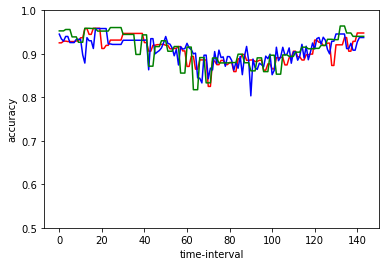

In [79]:
plt.xlabel('time-interval')
plt.ylabel('accuracy')
time = [i for i in range(144)]
plt.ylim(0.5, 1)
plt.plot(time, plt20_min_to_10, "r")
plt.plot(time, plt10_min_to_10, "b")
plt.plot(time, plt30_min_to_10, "g")
plt.savefig("different_tau_values.svg", format="svg")
plt.savefig("different_tau_values.pdf", format="pdf")
plt.show()

In [104]:
test35percent = [0.988, 0.9873, 0.987, 0.9624, 0.944, 0.9883, 0.988, 0.992, 0.9897, 0.9888, 0.986, 0.986, 0.9453, 0.988, 0.951, 0.8647, 0.9688, 0.9634, 0.9697, 0.934, 0.9253, 0.928, 0.8975, 0.8525, 0.8896, 0.9463, 0.9043, 0.8804, 0.918, 0.9126, 0.932, 0.8955, 0.923, 0.8916, 0.945, 0.9653, 0.9688, 0.9595, 0.969, 0.9253, 0.977, 0.9727, 0.9824, 0.9785, 0.988, 0.966, 0.9863, 0.987]

In [103]:
max(test35percent)

9126

In [99]:
name = "/home/sepehr/thesis/APDataML/6class_LR_noPenalty_normal.pickle"
with open(name, 'rb') as handle:
    plt30 = pickle.load(handle)   
test25_10precent = plt30["accuracy"].tolist()

In [95]:
name = "/home/sepehr/thesis/APDataML/result_25Only_5class_DataFrameNoPenalty.pickle"
with open(name, 'rb') as handle:
    plt30 = pickle.load(handle)
test25precent = plt30["accuracy"].tolist()

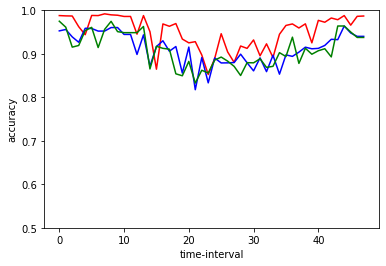

In [109]:
plt.xlabel('time-interval')
plt.ylabel('accuracy')
time = [i for i in range(48)]
plt.ylim(0.5, 1)
plt.plot(time, test35percent, "r")
plt.plot(time, test25_10precent, "b")
plt.plot(time, test25precent, "g")
plt.savefig("constraints_diff.svg", format="svg")
plt.savefig("constraints_diff.pdf", format="pdf")
plt.show()

In [ ]:
print("a")